# The final plots

The following cell downloads the preprocessed data from [zenodo](https://sandbox.zenodo.org/record/812722#.YJQ5NC9h2wI).
> During the submission this is still kept in the 'zenodo sandbox' repository, but will be submitted as permanent archive before submission.

The files are quite large and this can take a while (~30 min) depending on connection speeds.

In [1]:
!cd ../ && ./scripts/download_zenodo_files.sh

/bin/bash: ./scripts/download_zenodo_files.sh: No such file or directory


In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import string
import pathlib
import cf_xarray
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from fastprogress.fastprogress import progress_bar
from scipy.stats import linregress


%config InlineBackend.figure_format = 'retina'

from xarrayutils.plotting import shaded_line_plot, letter_subplots, linear_piecewise_scale
from xarrayutils.filtering import filter_2D
from xarrayutils.utils import linear_trend, sign_agreement
from cmip6_preprocessing.grids import combine_staggered_grid

from busecke_etal_2021_aguadv.plotting import (
    jitter_plot,
    model_color_legend,
    polish_map,
    ScientificManualFormatter,
    o2_model_colors,
)

from busecke_etal_2021_aguadv.utils import (
    read_files,
    stci,
    region,
    omz_volume,
    convert_mol_m3_mymol_kg,
    replace_time
)

import warnings
warnings.filterwarnings("ignore")


# from aguadv_omz_busecke_2021.plotting import jitter_plot
# from aguadv_omz_busecke_2021.omz_tools import (
#     region,
#     omz_volume,
#     convert_mol_m3_mymol_kg,
# )
# from aguadv_omz_busecke_2021.utils import (
#     model_color_legend,
#     polish_map,
#     ScientificManualFormatter,
#     o2_model_colors,
#     read_files,
#     stci,
# )
# from aguadv_omz_busecke_2021.cmip6_stash import replace_time
%matplotlib inline

In [2]:
# global settings
o2_bin=80
freq = "5AS" # resample frequency for timeseries plots
median = True # use median for multi-model averages
# sig_level = 1/100
filter_win = 4 #horizontal filter kernel standard deviation (in grid cells)
bar_color = "0.65" # median bar color
bar_height = 0.2 # median bar height
model_jitter = 0.1 # random spread between models in the bar plots

historical_time = slice('1960','2000') # Reference period for historical averages
plotfolder = pathlib.Path('plots/') 

## Load preprocessed data

In [3]:
n_kwargs = {'use_cftime':True}
z_kwargs = {'consolidated':True, 'use_cftime':True}

In [4]:
data_path = pathlib.Path('../data/processed_collect')

# Load regridded z data
full_z = xr.open_dataset(data_path.joinpath('historical_mean_z_combined/pacific_z_combined.nc'), chunks={'model':1})

obs_z = xr.open_zarr(data_path.joinpath('obs/obs_z.zarr'), decode_times=False)

# load the stc data
ddict_stc = read_files(data_path.joinpath('pacific_meridional_overturning_filtered/'), pattern='temp*.nc')

# # Load data
# dfolder = data_path.joinpath('full_output')
# flist = list(dfolder.glob('full_output_*.zarr'))
# ddict_full = {f.stem.replace('full_output_', ''):xr.open_zarr(f, **z_kwargs) for f in flist}

# this is by far the largest data. Let me see how I can reduce the size
# Load data
dfolder = data_path.joinpath('omz_timeseries')
flist = list(dfolder.glob('omz_timeseries_*.zarr'))
ddict_full = {f.stem.replace('omz_timeseries_', ''):xr.open_zarr(f, **z_kwargs)[['omz_volume']] for f in flist}

# Load natural variability data
dfolder = data_path.joinpath('omz_natural_variability')
flist = list(dfolder.glob('omz_natural_variability_*.nc'))
ddict_nat_var = {f.stem.replace('omz_natural_variability_', ''):xr.open_dataset(f, **n_kwargs) for f in flist}

# Load natural variability data for total OMZ
dfolder = data_path.joinpath('omz_natural_variability_total_omz')
flist = list(dfolder.glob('omz_natural_variability_total*.nc'))
ddict_nat_var_total = {f.stem.replace('omz_natural_variability_total_', ''):xr.open_dataset(f, **n_kwargs) for f in flist}

# Load trend data
dfolder = data_path.joinpath('linear_trends')
flist = list(dfolder.glob('linear_trends_*.zarr'))
ddict_omz_trend = {f.stem.replace('linear_trends_', ''):xr.open_zarr(f, **z_kwargs) for f in flist}

# regridded output
ds_historical_sigma = xr.open_zarr(data_path.joinpath('regridded_multimodel_output/historical_regridded_sigma.zarr/'), **z_kwargs)
ds_trend_sigma = xr.open_zarr(data_path.joinpath('regridded_multimodel_output/trend_regridded_sigma.zarr/'), **z_kwargs)
# There is a disntinutity in one of the norwegian models
ds_historical_sigma = ds_historical_sigma.chunk({'x':-1}).interpolate_na('x')
ds_trend_sigma = ds_trend_sigma.chunk({'x':-1}).interpolate_na('x')

# Trend output in z space
dfolder = pathlib.Path(data_path.joinpath('z_omz_vol_trends/'))
flist = list(dfolder.glob('*.nc'))
ddict_z_trend = {f.stem.replace('linear_trends_', ''):xr.open_mfdataset([f], **n_kwargs) for f in flist}

ds_obs_sigma = xr.open_dataset(data_path.joinpath('density_transform_obs/woa13.nc'))
# calculate the omz volume in the pacific only

ds_obs_sigma['omz_volume'] = omz_volume(region(ds_obs_sigma))

In [5]:
s_indicies = [[1], [2], [1, 2], [3]]
labels = ["Thermocline (TC)", "Intermediate Waters (IW)", "TC+IW", "Deep"]
proj = ccrs.PlateCarree(190)
crs = ccrs.PlateCarree()
map_kwargs = {"transform": crs, 'x':'lon', 'y':'lat'}
section_kwargs = {'yincrease':False, 'x':'y'}
hatch_kwargs = dict(colors='none', add_colorbar=False, add_labels=False)
sigma_contours = cf_xarray.bounds_to_vertices(ds_historical_sigma.isel(model=0).sigma_0_bounds, 'bnds').load().data[1:-1]
contour_kwargs = {'add_labels':False, 'add_colorbar':False}
nat_var_multiples = 2 #use +-2 stdv as natural variability everywhere!
models = np.sort(list(ddict_full.keys()))
n_models = len(ds_historical_sigma.model.data)

In [6]:
import matplotlib.colors as colors
# colors.ListedColormap()

# This cuts the cmocean colobar to not waste all that range on high o2 values 
# and avoid having colors in the colorbar that are not present in the picture
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=600):
    """n needs to be high to not interpolate colors in the original cmap"""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [7]:
def axhpatch(height, y=0, ax = None, **kwargs):
    if ax is None:
        ax = plt.gca()
        
    kwargs.setdefault('edgecolor','none')
        
    xlims = np.array(ax.get_xlim())
    left, bottom, width, height = (xlims[0], -height, xlims[1] - xlims[0], 2*height)
    rect = plt.Rectangle((left, bottom), width, height, **kwargs)
    ax.add_patch(rect)

## Figure 1 - Historical OMZ (obs and model)
<!-- ![image.png](attachment:1930aaf1-7300-49db-b583-2712af8a1ad2.png) -->

If anything I might want to make this  one more vertical to get it larger.

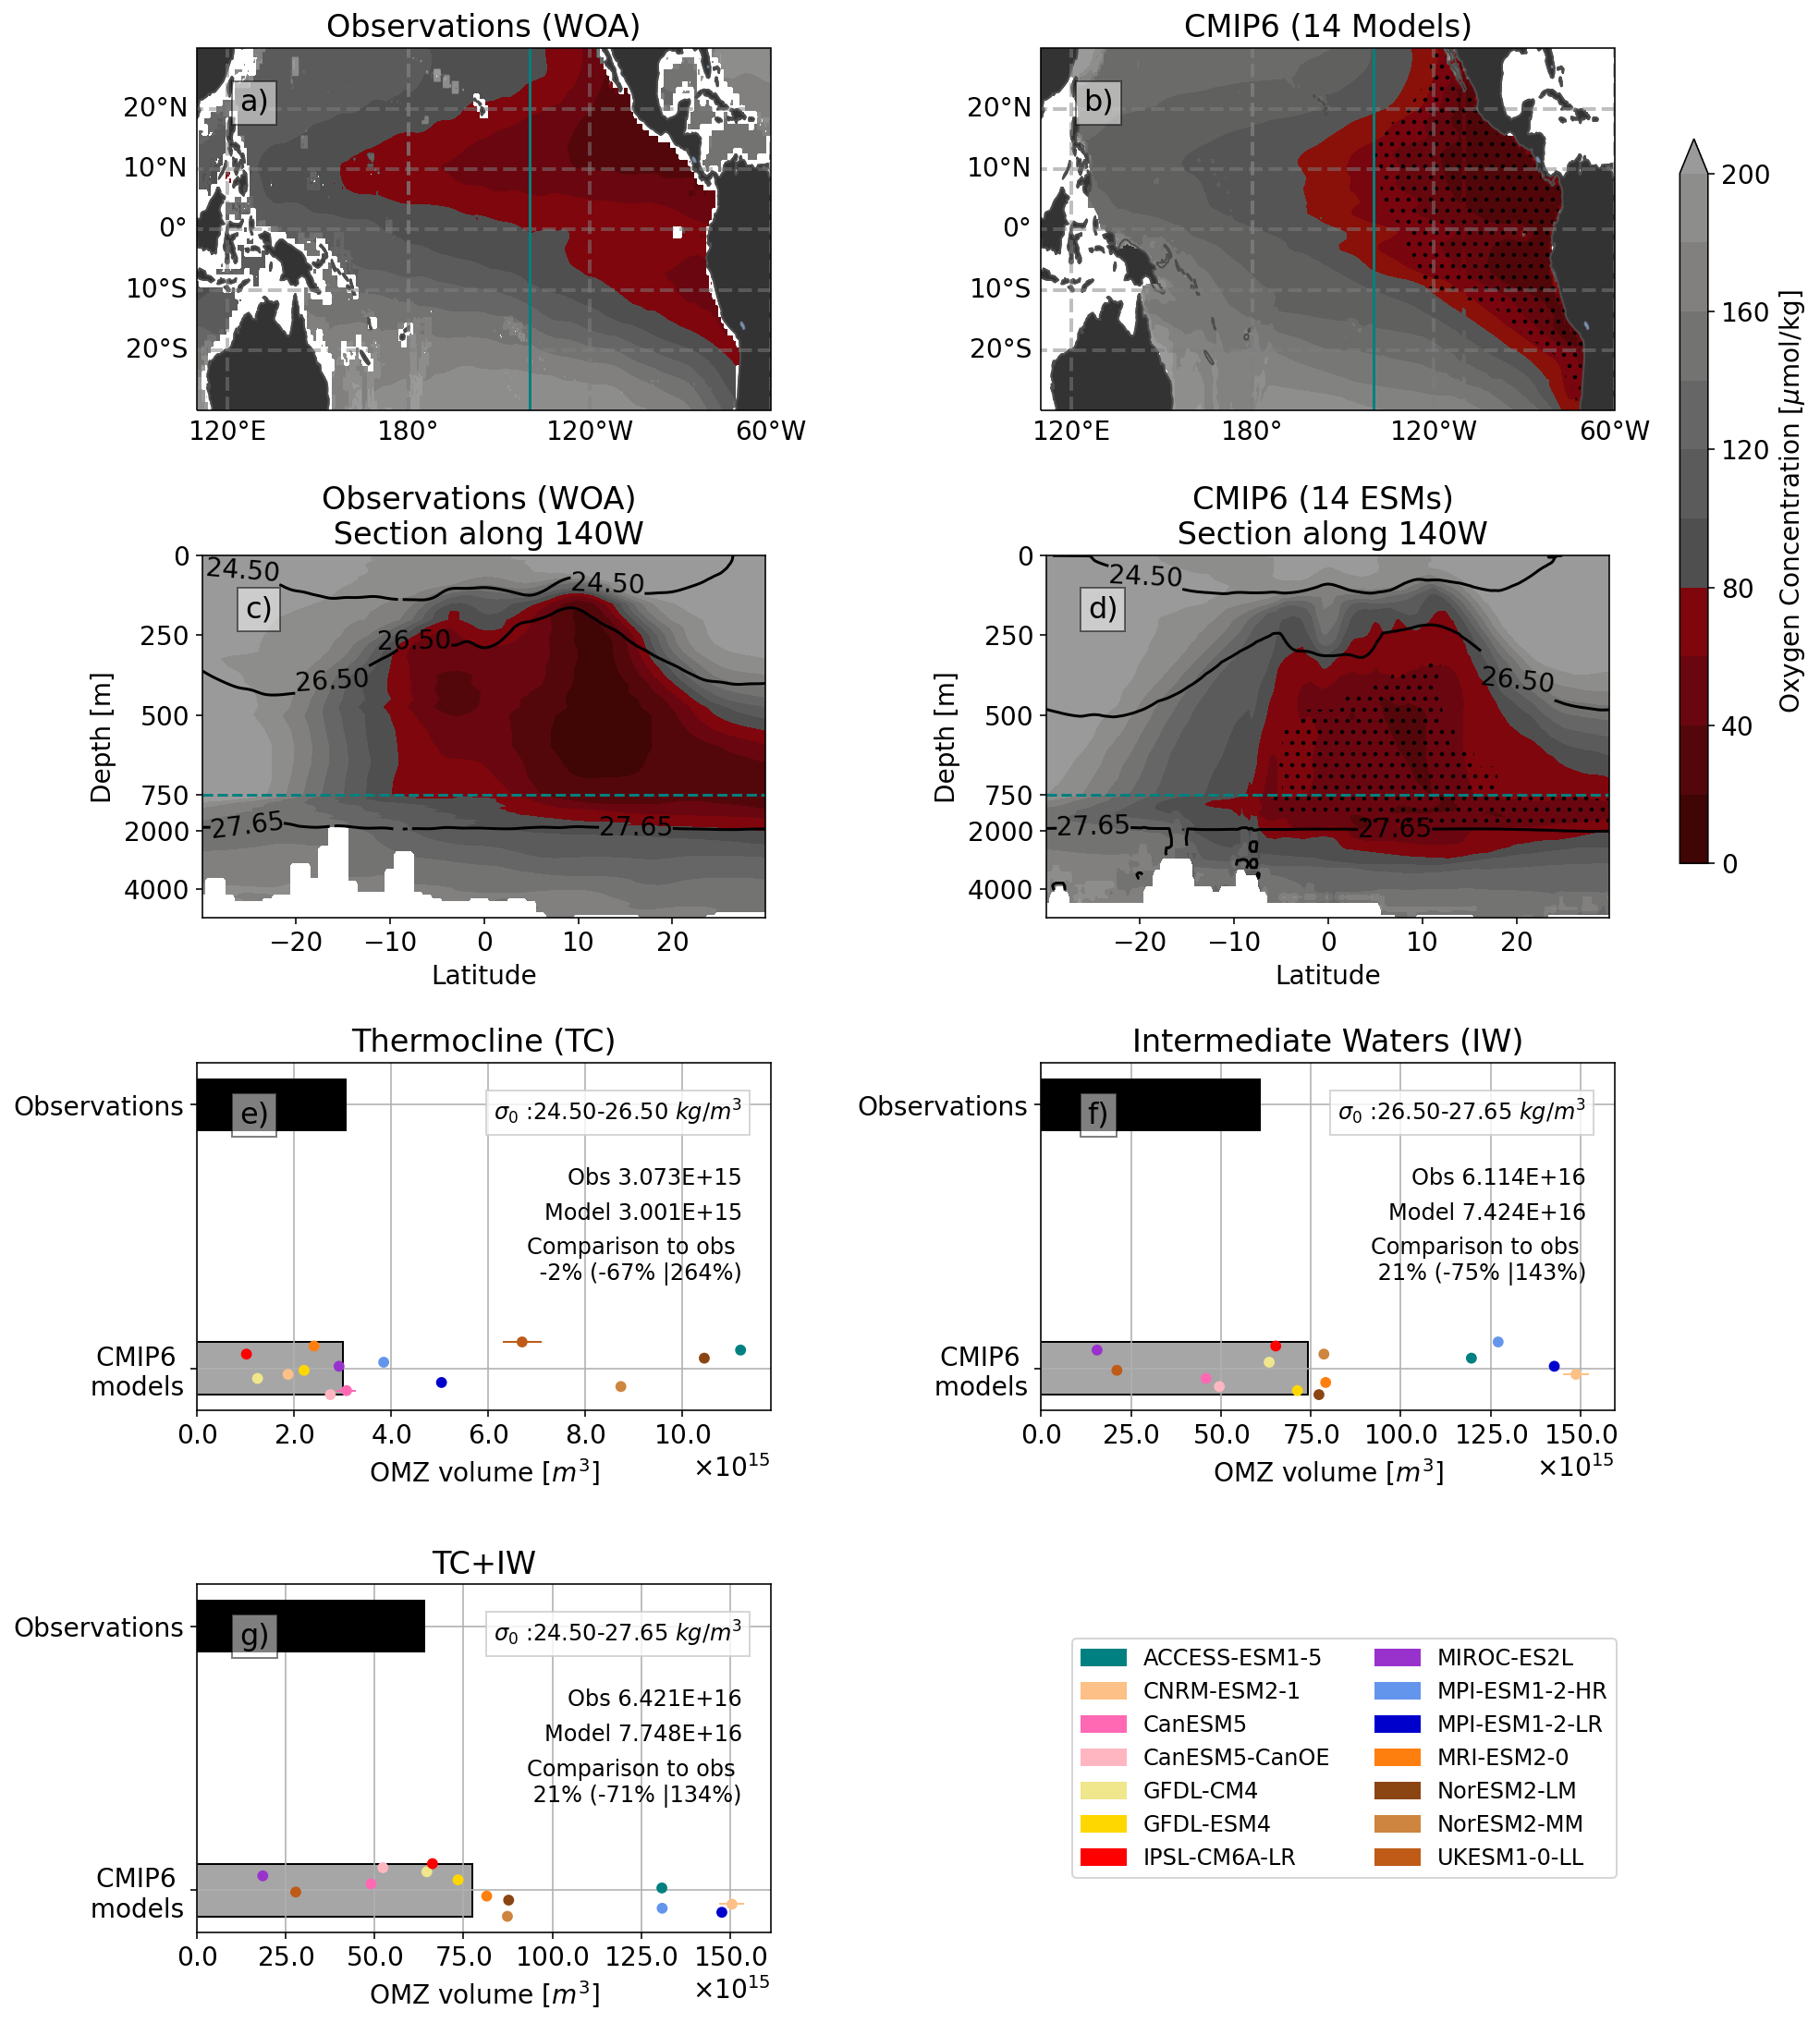

In [8]:
# Figure setup
scale_factor = 2  # just used to wiggle the text and symbol sizes around
fontsize = 7 * scale_factor
plt.rcParams["font.size"] = str(fontsize)
fig_aspect_ratio = 20 / 25
fig = plt.figure(
    constrained_layout=False,
    figsize=np.array([7.5, 7.5 / fig_aspect_ratio]) * scale_factor,
)
gs0 = fig.add_gridspec(4, 1, hspace=0.4)

gsmap = gs0[0].subgridspec(1, 2)
gssec = gs0[1].subgridspec(1, 2)
gsbar = gs0[2:].subgridspec(2, 2, hspace=0.5)

map_axarr = []
for ii in range(2):
    ax = fig.add_subplot(gsmap[ii], projection=proj)
    map_axarr.append(ax)

section_axarr = []
for ii in range(2):
    ax = fig.add_subplot(gssec[ii])
    section_axarr.append(ax)

bar_axarr = []
for a in range(3):
    ax = fig.add_subplot(gsbar[a])
    bar_axarr.append(ax)


color_kwargs = dict(
    vmin=0, vmax=200, levels=11, cmap=truncate_colormap(cmo.oxy, 0, 0.5)
)  # , rasterized=True

ref_lon = 220


# # ###############################       vol bars       ####################################
for s_idx, label, ax, ax_lim_format in zip(
    s_indicies[0:3], labels, bar_axarr, [15, 15, 15, 15]
):

    # observed volume
    obs_vol = (
        ds_obs_sigma.omz_volume.sel(o2_bin=o2_bin).isel(sigma_0=s_idx).sum("sigma_0")
    )
    # historical volume for each model
    model_vol = {
        model: ds.omz_volume.sel(time=historical_time, o2_bin=o2_bin)
        .isel(sigma_0=s_idx)
        .sum("sigma_0")
        for model, ds in ddict_full.items()
    }
    model_mean = {model: ds.mean("time").load() for model, ds in model_vol.items()}
    model_std = {model: ds.std("time").load() for model, ds in model_vol.items()}

    model_member_averaged = jitter_plot(0, model_mean, ax=ax, model_jitter_amount=model_jitter)

    # compare to observed value
    ax.barh(1, obs_vol, color="k", height=bar_height)

    # Model mean

    mean_vol = np.median(model_member_averaged)
    ax.barh(0, mean_vol, edgecolor="k", height=bar_height, facecolor=bar_color, zorder=0)

    ax.set_axisbelow(True)
    ax.grid()

    ax.set_xlabel("OMZ volume [$m^3$]")
    # this might have to be adjusted?
    sigma_bounds = [
        ds_historical_sigma.isel(sigma_0=s_idx).sigma_0_bounds.min().load().data,
        ds_historical_sigma.isel(sigma_0=s_idx).sigma_0_bounds.max().load().data,
    ]

    ax.set_title(f"{label}")
    ax.xaxis.set_major_formatter(ScientificManualFormatter(ax_lim_format, "%1.1f"))
    ax.ticklabel_format(
        axis="x", style="sci", scilimits=(-ax_lim_format, ax_lim_format)
    )
    ax.set_yticks([0, 1])
    ax.set_yticklabels(
        [
            "CMIP6 \n models",
            "Observations",
        ],
    )

    # add the percent difference of the mean/median and Range of single models
    obs_vol = np.array(obs_vol)
    comparison_perc = (mean_vol - obs_vol) / obs_vol * 100
    comparison_min = np.min((model_member_averaged - obs_vol) / obs_vol * 100)
    comparison_max = np.max((model_member_averaged - obs_vol) / obs_vol * 100)

    ax.text(
        0.95,
        0.9,
        f"$\sigma_0$ :{sigma_bounds[0]:.2f}-{sigma_bounds[1]:.2f} $kg/m^3$",
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax.transAxes,
        fontsize=12,
        bbox=dict(facecolor='w', alpha=0.8, edgecolor='0.8')
    )

    ax.text(
        0.95,
        0.7,
        f"Obs {obs_vol:.3E}",
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax.transAxes,
        fontsize=12,
    )

    ax.text(
        0.95,
        0.6,
        f"Model {mean_vol:.3E}",
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax.transAxes,
        fontsize=12,
    )

    ax.text(
        0.95,
        0.5,
        f"Comparison to obs \n {comparison_perc:.0f}% ({comparison_min:.0f}% |{comparison_max:.0f}%)",
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax.transAxes,
        fontsize=12,
    )


################################    thermocline o2 map   ####################################
ax = map_axarr[0]
o2_obs = convert_mol_m3_mymol_kg(ds_obs_sigma.o2).isel(sigma_0=[1, 2])
o2_obs = o2_obs.weighted(o2_obs.dz_t.fillna(0)).mean("sigma_0")
im = o2_obs.plot.contourf(ax=ax, **map_kwargs, **color_kwargs, add_colorbar=False)
polish_map(ax)
ax.set_aspect(2)
ax.set_title("Observations (WOA)")

ax = map_axarr[1]
o2 = convert_mol_m3_mymol_kg(ds_historical_sigma.o2).isel(sigma_0=[1, 2])
o2 = o2.weighted(o2.dz_t.fillna(0)).mean("sigma_0")
omz_agreement = (o2 <= o2_bin).sum("model") >= (0.75 * n_models)

median = True
if median:
    o2 = o2.median("model")
else:
    o2 = o2.mean("model")

im = o2.plot.contourf(ax=ax, **map_kwargs, **color_kwargs, add_colorbar=False)
omz_agreement.plot.contourf(
    ax=ax, levels=[0, 0.5], hatches=[None, ".."], **hatch_kwargs, **map_kwargs
)
polish_map(ax)
ax.set_aspect(2)
ax.set_title(f"CMIP6 ({n_models} Models)")

# indicate section on plot
for ax in map_axarr:
    ax.plot([ref_lon, ref_lon], [-30, 30], transform=crs, color="teal")

# ################################ o2 section depth ####################################
ax = section_axarr[0]
o2 = convert_mol_m3_mymol_kg(obs_z.o2).interp(x=ref_lon)
sigma = obs_z.sigma_0.interp(x=ref_lon)

im = o2.plot.contourf(ax=ax, **color_kwargs, add_colorbar=False, **section_kwargs)
ch_dens = sigma.plot.contour(
    ax=ax, levels=sigma_contours, colors="k", **section_kwargs, **contour_kwargs
)
plt.clabel(ch_dens, fmt="%.2f")
ax.set_title(f"Observations (WOA) \n Section along {360-ref_lon}W")

ax = section_axarr[1]
o2 = convert_mol_m3_mymol_kg(full_z.o2).interp(
    x=ref_lon
)  # .sel(experiment="historical")
sigma = full_z.sigma_0.interp(x=ref_lon)  # .sel(experiment="historical")
omz_agreement = (o2 <= o2_bin).sum("model") >= (0.75 * n_models)

if median:
    o2 = o2.median("model")
    sigma = sigma.median("model")
else:
    o2 = o2.mean("model")
    sigma = sigma.mean("model")

im = o2.plot.contourf(ax=ax, **color_kwargs, add_colorbar=False, **section_kwargs)
ch_dens = sigma.plot.contour(
    ax=ax, levels=sigma_contours, colors="k", **section_kwargs, **contour_kwargs
)
plt.clabel(ch_dens, fmt="%.2f")

omz_agreement.plot.contourf(
    ax=ax, levels=[0, 0.5], hatches=[None, ".."], **hatch_kwargs, **section_kwargs
)
ax.set_title(f"CMIP6 ({n_models} ESMs) \n Section along {360-ref_lon}W")

for ax in section_axarr:
    linear_piecewise_scale(750, 10, ax=ax)
    ax.axhline(750, color="teal", ls="--")
    # indicate the point between the different scalings
    ax.set_ylim(5000, 0)
    # Rearange the yticks
    ax.set_yticks([0, 250, 500, 750, 2000, 4000])
    ax.set_ylabel("Depth [m]")
    ax.set_xlabel("Latitude")
    ax.set_aspect(1 / 325)

# ############################################################################################
# set global colorbar
cbar_ax = section_axarr[1]
axins = inset_axes(
    cbar_ax,
    #     width="200%",  # width = 50% of parent_bbox width
    #     height="10%",  # height : 5%
    width="5%",  # width = 50% of parent_bbox width
    height="200%",  # height : 5%
    bbox_to_anchor=(0.65, 0.65, 1, 1),
    bbox_transform=cbar_ax.transAxes,
    loc="center",
)

cbar = fig.colorbar(
    im,
    cax=axins,
    orientation="vertical",
    ticks=np.arange(0, 400, 40),
    label=f"Oxygen Concentration [$\mu$mol/kg]",
)

# Label subplots
letter_subplots(
    np.array(map_axarr + section_axarr + bar_axarr), box_color="w", fontsize=16
)

# add colorlegend for models
model_color_legend(
    bar_axarr[-1],
    models=models,
    ncol=2,
    loc="center",
    fontsize=12,
    bbox_to_anchor=(2.0, 0.5),
)

# manually force the axes into same position
for ax in [section_axarr[0], bar_axarr[0], bar_axarr[2]]:
    ref_pos = map_axarr[0].get_position()
    pos = ax.get_position()
    ax.set_position((ref_pos.x0, pos.y0, ref_pos.width, pos.height))

for ax in [section_axarr[1], bar_axarr[1]]:
    ref_pos = map_axarr[1].get_position()
    pos = ax.get_position()
    ax.set_position((ref_pos.x0, pos.y0, ref_pos.width, pos.height))


fig.savefig(plotfolder.joinpath("Figure1.pdf"), bbox_inches="tight")  # , dpi=600
plt.show()

## Figure 2 - Projected OMZ changes

### Notes
- New panel looks sick!
    *But* the members are definitely too much. How do I present them? In the appendix as a table?
- Decide on a final measure of change. Linear trend over 100 years * 100 years?
- The bar plot and the timeseries is a bit redundant. What do I want to tell with which?

<!-- ![image.png](attachment:611c5aca-c3ab-4c34-b049-b2e6f8cf0207.png) -->

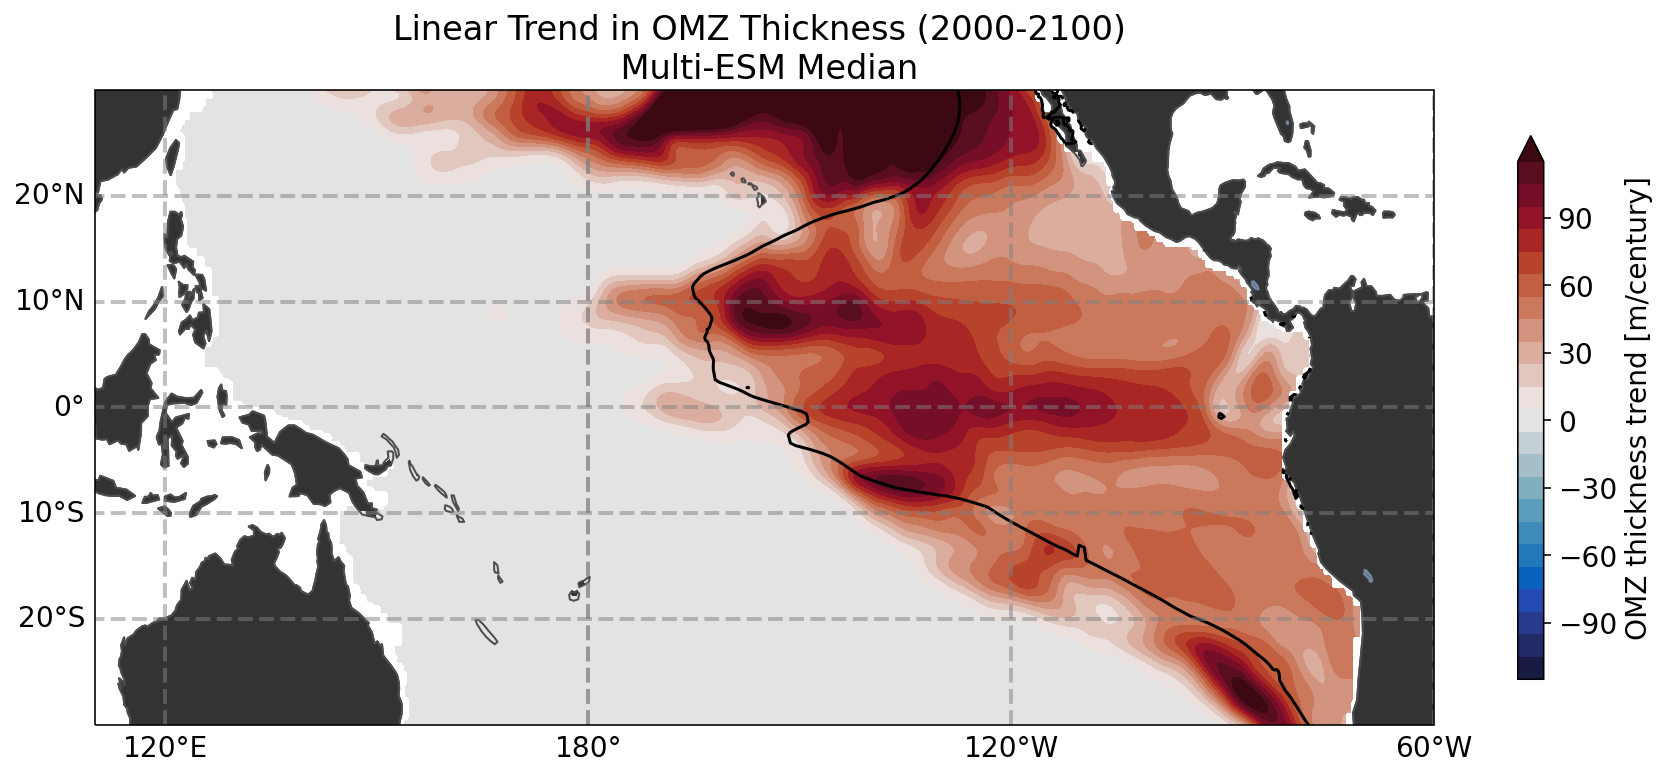

In [9]:
scale_factor = 2  # just used to wiggle the text and symbol sizes around
fontsize = 7 * scale_factor
plt.rcParams["font.size"] = str(fontsize)
fig_aspect_ratio = 20 / 25
fig, ax_map = plt.subplots(
    figsize=np.array([7.5, 2.5 / fig_aspect_ratio]) * scale_factor,
    subplot_kw=dict(projection=proj),
)

######################## Multi-Model mean in OMZ thickness ####################################
idx = s_indicies[2]
label = labels[2]
ax = ax_map

ref_o2 = ds_historical_sigma.isel(sigma_0=idx)
ref_o2 = ref_o2.o2.weighted(ref_o2.dz_t.fillna(0)).mean("sigma_0")

slope_omz_thick = ds_trend_sigma.omz_thickness
slope_omz_thick = slope_omz_thick.sel(parameter="slope") * 100
slope_omz_thick = slope_omz_thick.sel(o2_bin=o2_bin).isel(sigma_0=idx).sum("sigma_0")
mask = np.isnan(ref_o2).sum("model") > 2
slope_omz_thick = slope_omz_thick.where(~mask)


if median:
    slope_omz_thick = slope_omz_thick.median("model")
    ref_o2 = ref_o2.median("model")
else:
    slope_omz_thick = slope_omz_thick.mean("model")
    ref_o2 = ref_o2.mean("model")

# Filtering
slope_omz_thick = filter_2D(
    slope_omz_thick.chunk({"x": -1, "y": -1}), filter_win, ["y", "x"]
)

tick_levels = np.arange(-120, 140, 30)
levels = np.arange(-115, 120, 10)

slope_omz_thick.plot.contourf(
    ax=ax,
    robust=True,
    center=0,
    vmax=100,
    cmap=cmo.balance,
    levels=levels,
    cbar_kwargs={
        "label": "OMZ thickness trend [m/century]",
        "shrink": 0.80,
        "ticks": tick_levels,
    },
    **map_kwargs,
)

convert_mol_m3_mymol_kg(ref_o2).plot.contour(
    ax=ax,
    levels=[-1e10,o2_bin],
    colors=["k"],
    add_colorbar=False,
    add_labels=False,
    **map_kwargs,
)
# median looks a little nicer?
ax.set_title(
    f"Linear Trend in OMZ Thickness (2000-2100) \n Multi-ESM {'Median' if median else 'Mean'}"
)

polish_map(ax, crs=crs)

fig.savefig(plotfolder.joinpath("futuremap.pdf"), bbox_inches="tight")
plt.show()

## Fig 3 - Future OMZ volume

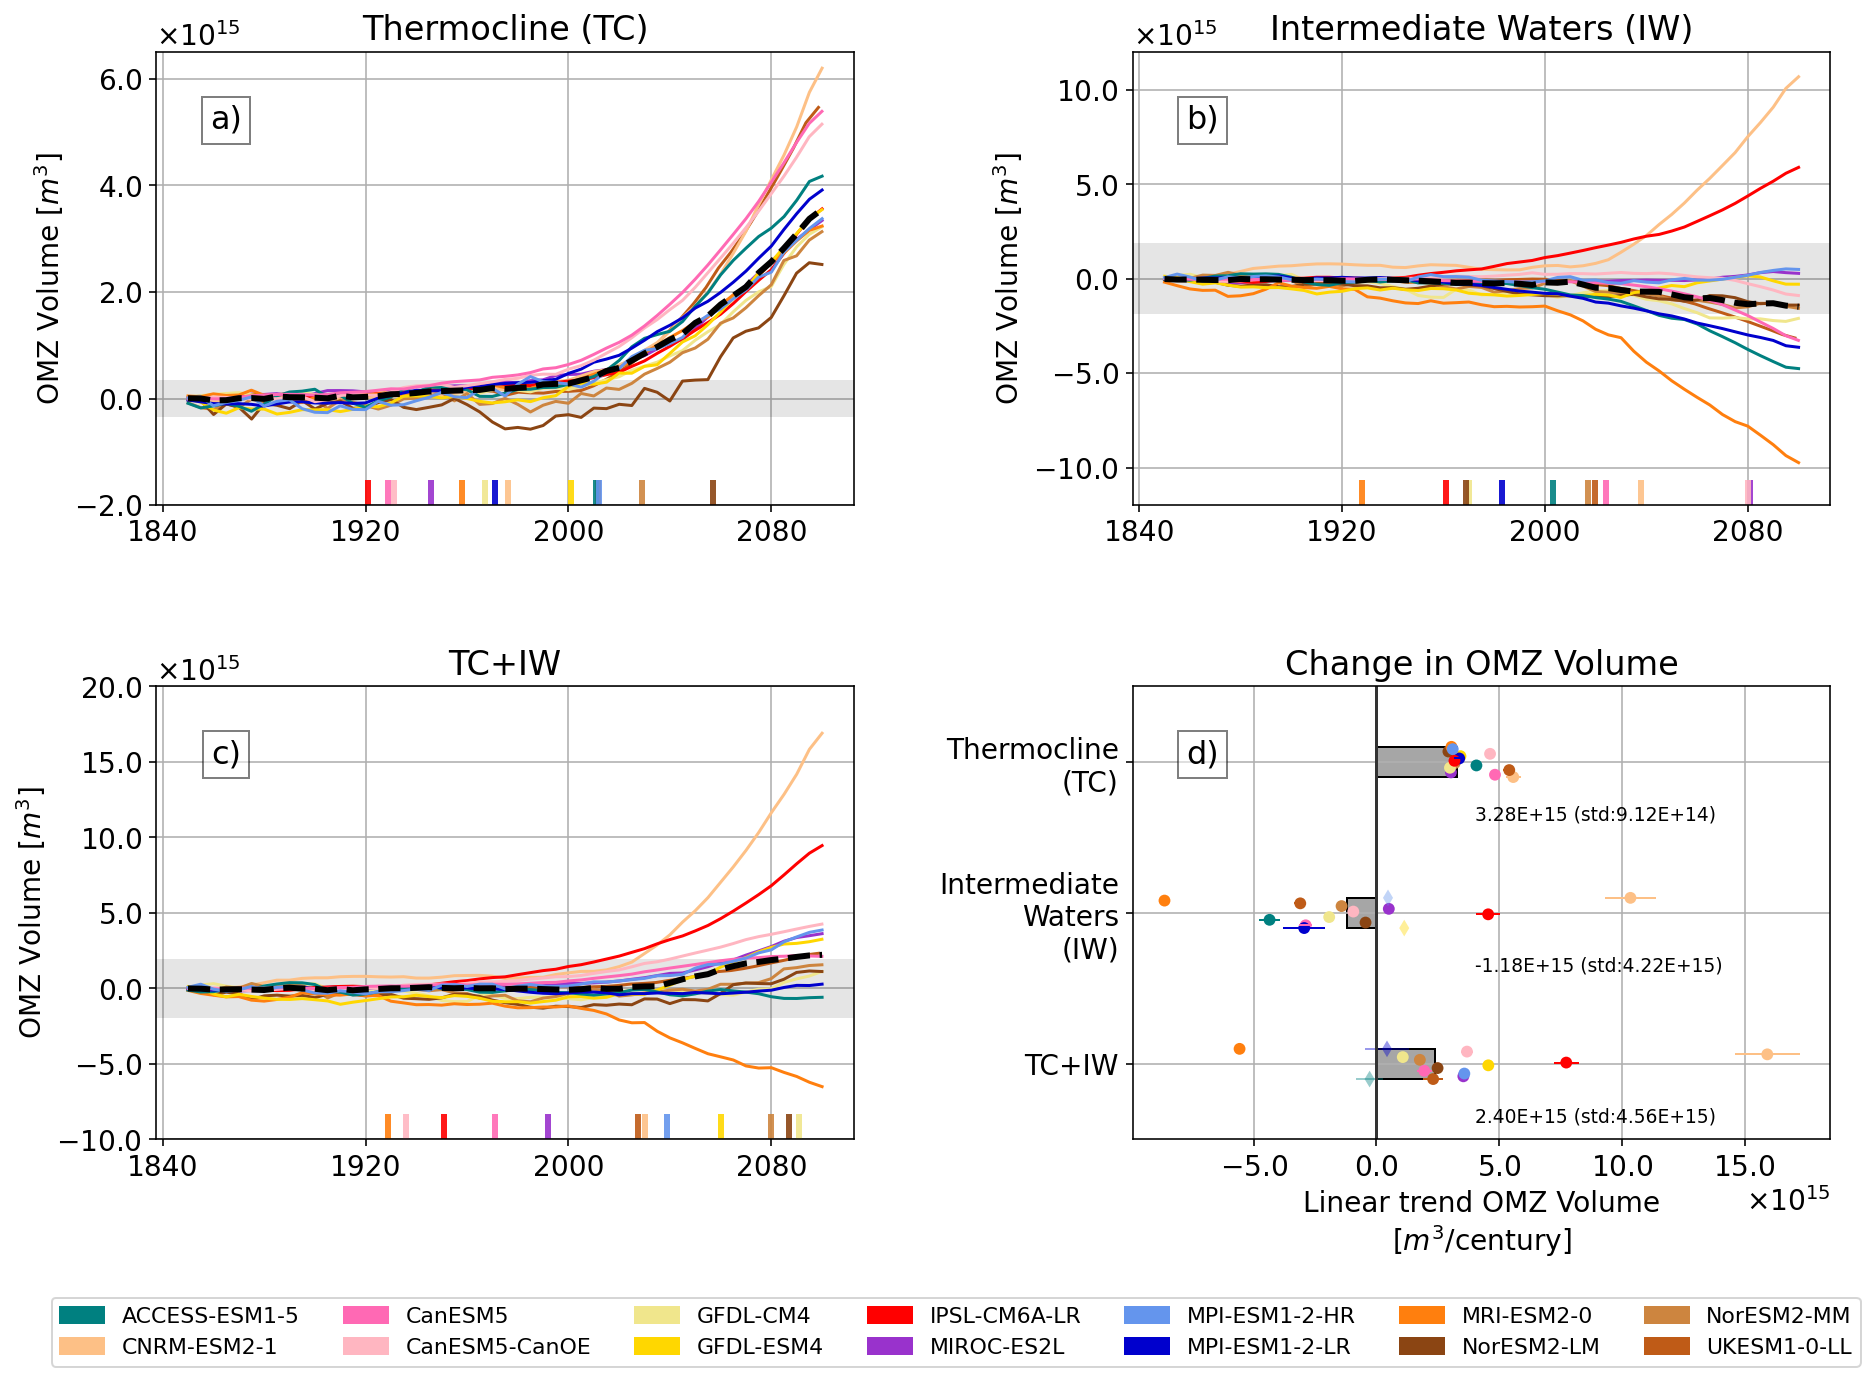

In [11]:
scale_factor = 2  # just used to wiggle the text and symbol sizes around
fontsize = 7 * scale_factor
plt.rcParams["font.size"] = str(fontsize)

fig, axarr_ts = plt.subplots(
    ncols=2, nrows=2, figsize=np.array([7.5, 5]) * scale_factor
)
axarr_ts = list(axarr_ts.flat)
ax_bar = axarr_ts[-1]

bar_ticks = np.arange(len(s_indicies))


#### Bar plots #####
for s_idx, y, label in zip(s_indicies[0:3], bar_ticks[0:3], labels[0:3]):

    # historical volume for each model
    model_vol = {
        model: (ds.omz_volume.sel(o2_bin=o2_bin, parameter="slope"))
        .isel(sigma_0=s_idx)
        .sum("sigma_0")
        for model, ds in ddict_omz_trend.items()
    }

    if s_idx == [1, 2]:
        model_nat_var = {
            model: (ds.omz_volume_natural_variability.sel(o2_bin=o2_bin))
            for model, ds in ddict_nat_var_total.items()
        }
    else:
        model_nat_var = {
            model: (ds.omz_volume_natural_variability.sel(o2_bin=o2_bin)).isel(
                sigma_0=s_idx
            )
            for model, ds in ddict_nat_var.items()
        }

    model_mean = {model: (da * 100).load() for model, da in model_vol.items()}

    # average the members together if appropriate
    model_nat_var = {
        model: da.mean("member_id") if "member_id" in da.dims else da
        for model, da in model_nat_var.items()
    }
    model_mean_check = {
        model: da.mean("member_id") if "member_id" in da.dims else da
        for model, da in model_mean.items()
    }

    # split up versions that do not exceed the natural variability
    model_mean_significant = {
        model: da
        for model, da in model_mean.items()
        if abs(model_mean_check[model].data)
        > nat_var_multiples * model_nat_var[model].data
    }
    model_mean_insignificant = {
        model: da
        for model, da in model_mean.items()
        if model not in model_mean_significant.keys()
    }

    model_member_averaged_significant = jitter_plot(
        y,
        model_mean_significant,
        ax=ax_bar,
        marker="o",
        model_jitter_amount=model_jitter,
        s=40,
    )
    if len(model_mean_insignificant) > 0:
        model_member_averaged_insignificant = jitter_plot(
            y,
            model_mean_insignificant,
            ax=ax_bar,
            marker="d",
            model_jitter_amount=model_jitter,
            alpha=0.4,
            s=10,
        )

        # Model mean
        model_member_averaged = np.hstack(
            [model_member_averaged_insignificant, model_member_averaged_significant]
        )
    else:
        # Model mean
        model_member_averaged = model_member_averaged_significant

    # add the total change and std of models as text
    ax_bar.text(
        4e15,
        y + 0.35,  # a bit hacky...
        f"{np.median(model_member_averaged):.2E} (std:{np.std(model_member_averaged):.2E})",
        horizontalalignment="left",
        verticalalignment="center",
        fontsize=fontsize / 3 * 2,
    )

    mean_vol = np.median(model_member_averaged)
    ax_bar.set_axisbelow(True)
    ax_bar.barh(
        y, mean_vol, edgecolor="k", height=bar_height, facecolor=bar_color, zorder=0
    )
    ax_bar.grid(zorder=-1)


# set the exponent to 15 for the bar plot
ax_bar.xaxis.set_major_formatter(ScientificManualFormatter(15, "%1.1f"))
ax_bar.ticklabel_format(axis="x", style="sci", scilimits=(-15, 15))

ax_bar.axvline(0, color="0.2")
# # ax_bar.set_title(label)
ax_bar.set_yticks(bar_ticks[0:3])
ax_bar.set_yticklabels(
    [
        l.replace(" ", "\n") for l in labels[0:3]
    ],  # ha="right", va="center" #rotation=90,
)
ax_bar.set_ylim([-0.5, 2.5])
ax_bar.invert_yaxis()


ax_bar.set_xlabel("Linear trend OMZ Volume\n[$m^3$/century]")
ax_bar.set_title("Change in OMZ Volume")

# ######################################## timeseries ##############################################


def concat_multi_model(datasets):
    if "time" in datasets[0].dims:
        datasets = [
            replace_time(ds, ref_date=ds.time.data[0], calendar="standard", freq=freq)
            for ds in datasets
        ]
    return xr.concat(
        datasets,
        dim="model",
        compat="override",
        coords="minimal",
        join="override",
    )


for sigma_idx, ax, ylims, label in zip(
    [[1], [2], [1, 2]],
    axarr_ts,
    [(-2e15, 6.5e15), (-12e15, 12e15), (-10e15, 20e15)],
    labels,
):
    multimodel = []
    max_variability = []
    for model, ds in ddict_full.items():

        color = o2_model_colors()[model]

        # restrict to 1850-2100 (IPSL and CanESM have longer members)
        ds = ds.sel(time=slice("1850", "2100"))

        if sigma_idx == [1, 2]:
            ds_nat_var = ddict_nat_var_total[model]
        else:
            ds_nat_var = ddict_nat_var[model].isel(sigma_0=sigma_idx)

        ds = ds.sel(o2_bin=o2_bin).isel(sigma_0=sigma_idx).sum(["sigma_0"])
        ds_nat_var = ds_nat_var.sel(o2_bin=o2_bin)

        omz_vol = ds.omz_volume
        natural_variability = (
            ds_nat_var.omz_volume_natural_variability * nat_var_multiples
        )

        # if there are several members, average them
        if "member_id" in omz_vol.dims:
            omz_vol = omz_vol.mean("member_id")

        if "member_id" in natural_variability.dims:
            natural_variability = natural_variability.mean("member_id")
        max_variability.append(natural_variability)

        # remove the baseline, so the mean value starts at 0
        baseline = omz_vol.isel(time=0)
        omz_vol = omz_vol - baseline

        # indicate the "time of emergence" based on the yearly data
        # find the last index of data that is within the natural variability.
        emerge_idx = np.max(
            np.argwhere((abs(omz_vol) <= natural_variability).load().data)
        )
        emerge_idx = emerge_idx + 1 if emerge_idx < len(omz_vol.time) - 2 else False
        emerge_time = omz_vol.time[emerge_idx].data.tolist() if emerge_idx else False

        # smooth for 5 years
        omz_vol = omz_vol.resample(time=freq).mean()
        # append the resampled data to
        multimodel.append(omz_vol)

        omz_vol.plot(ax=ax, color=color, lw=1.5, add_legend=False)

        if emerge_time:
            ax.plot(
                np.array([emerge_time, emerge_time]),
                [ylims[0], ylims[0] + (0.05 * (ylims[1] - ylims[0]))],
                color=color,
                lw=3,
                alpha=0.9,
            )

    ds_multimodel = concat_multi_model(multimodel).median("model")
    ds_max_var = concat_multi_model(max_variability).max("model")
    ds_multimodel.plot(ax=ax, color="k", lw=3, ls="--")

    ax.set_axisbelow(True)
    axhpatch(ds_max_var, edgecolor="none", facecolor="k", alpha=0.1, ax=ax)

    ax.grid()
    ax.set_ylim(ylims)
    ax.set_title(label)
    ax.set_xlabel("")
    ax.set_ylabel("OMZ Volume [$m^3$]")

    # set the exponent to 15 for the bar plot
    ax.yaxis.set_major_formatter(ScientificManualFormatter(15, "%1.1f"))
    ax.ticklabel_format(axis="y", style="sci", scilimits=(-15, 15))
# pos = ax_bar.get_position()
# ax_bar.set_position((pos.x0, pos.y0, pos.width/2, pos.height))
letter_subplots(np.array(axarr_ts), box_color="w", fontsize=16)


# add colorlegend for models (next to the map saves space)
model_color_legend(
    axarr_ts[-1],
    models=models,
    bbox_to_anchor=(-1.55, -0.35),
    ncol=7,
    fontsize=5.5 * scale_factor,
)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.savefig(plotfolder.joinpath("futureomz.pdf"), bbox_inches="tight")
plt.show()

## Figure 4 - Relationship between STC and OMZ volume in the thermocline

- For the revision: Add more members

Age median full region:76.44194766859012
Age: At least 4.0/10 dissagree
Oxygen median full region:-22.93104236369896
Oxygen: At least 5.0/14 dissagree
OUR median full region:0.08575501244190713
OUR: At least 4.0/10 dissagree
Regression -10.901735204897035 $\pm$3.078101510115185 Significance: 99.5941938392132%


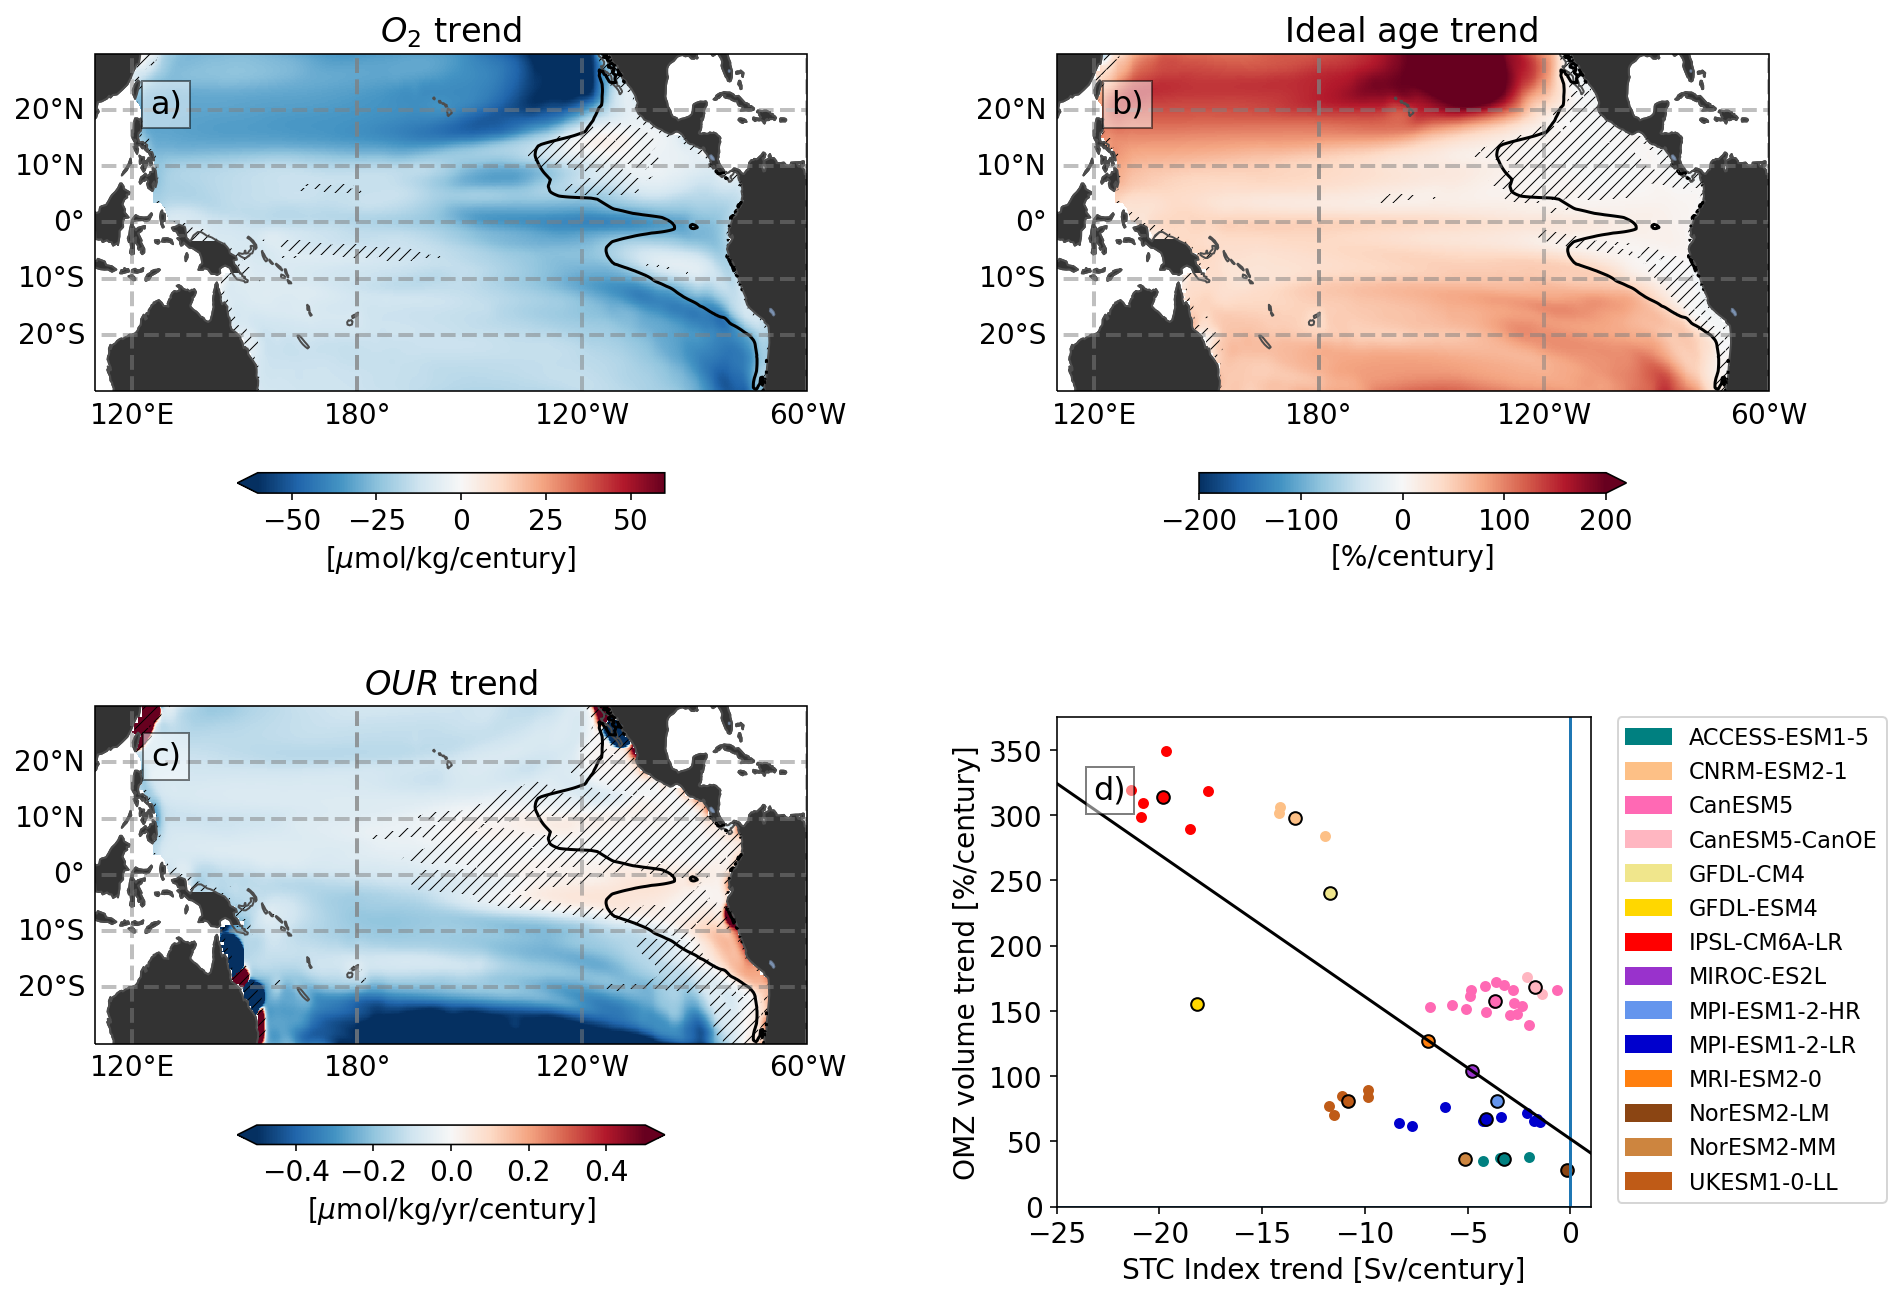

In [12]:
plt.rcParams["hatch.color"] = "k"
plt.rcParams["hatch.linewidth"] = 0.5

scale_factor = 2  # just used to wiggle the text and symbol sizes around
fontsize = 7 * scale_factor
plt.rcParams["font.size"] = str(fontsize)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ######################### Figure setup ##################################
    fig = plt.figure(
        constrained_layout=False, figsize=np.array([7.5, 5.5]) * scale_factor
    )
    gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.35)
    ax_scatter = fig.add_subplot(gs[1, 1])
    ax_o2 = fig.add_subplot(gs[0, 0], projection=proj)
    ax_age = fig.add_subplot(gs[0, 1], projection=proj)
    ax_our = fig.add_subplot(gs[1, 0], projection=proj)

    threshold = 0.65
    s_idx = 1

    # maps
    ds = ds_trend_sigma.isel(sigma_0=s_idx).sel(o2_bin=o2_bin)
    ds_hist = ds_historical_sigma.isel(sigma_0=s_idx).sel(o2_bin=o2_bin)

    ds = ds.sel(parameter="slope")  # .where(ds.sel(parameter='p_value') < sig_level)
    ds = ds * 100
    ds_percentage = ds / ds_hist * 100
    ref_o2 = convert_mol_m3_mymol_kg(ds_hist.o2).median("model")

    # recalculate metrics for the new grid
    ds.attrs["grid_label"] = "gr"
    ds.attrs[
        "source_id"
    ] = "GFDL-CM4"  # this should work without this just assuming an a grid
    grid, ds = combine_staggered_grid(ds, recalculate_metrics=True)
    ds.coords["areacello"] = ds.dx_t * ds.dy_t
    ds_percentage.coords["areacello"] = ds.dx_t * ds.dy_t

    ax = ax_age
    data = ds_percentage.agessc
    data = data.where(~np.isnan(data).all(["x", "y"]), drop=True)
    print(
        f"Age median full region:{data.weighted(data.areacello).mean(['x','y']).load().median('model').data}"
    )
    ref = filter_2D(
        data.median("model").chunk({"x": -1, "y": -1}), filter_win, ["y", "x"]
    )
    non_agreement = sign_agreement(data, ref, "model", threshold=threshold)
    print(
        f"Age: At least {np.ceil(len(data.model)*(1-threshold))}/{len(data.model)} dissagree"
    )
    ref.plot(
        ax=ax,
        vmax=200,
        cbar_kwargs={
            "label": "[%/century]",
            "shrink": 0.6,
            "orientation": "horizontal",
        },
        **map_kwargs,
    )

    non_agreement.plot.contourf(
        ax=ax, levels=[0, 0.5], hatches=["////", None], **hatch_kwargs, **map_kwargs
    )
    ref_o2.plot.contour(
        ax=ax, levels=[-1e10, o2_bin], colors="k", add_title=False, **map_kwargs
    )
    ax.set_title(f"Ideal age trend")
    polish_map(ax)

    ax = ax_o2
    data = convert_mol_m3_mymol_kg(ds.o2)
    data = data.where(~np.isnan(data).all(["x", "y"]), drop=True)
    print(
        f"Oxygen median full region:{data.weighted(data.areacello).mean(['x','y']).load().median('model').data}"
    )
    ref = filter_2D(
        data.median("model").chunk({"x": -1, "y": -1}), filter_win, ["y", "x"]
    )
    non_agreement = sign_agreement(data, ref, "model", threshold=threshold)
    print(
        f"Oxygen: At least {np.ceil(len(data.model)*(1-threshold))}/{len(data.model)} dissagree"
    )
    ref.plot(
        ax=ax,
        vmax=60,
        cbar_kwargs={
            "label": "[$\mu$mol/kg/century]",
            "shrink": 0.6,
            "orientation": "horizontal",
        },
        **map_kwargs,
    )

    non_agreement.plot.contourf(
        ax=ax, levels=[0, 0.5], hatches=["////", None], **hatch_kwargs, **map_kwargs
    )
    ref_o2.plot.contour(
        ax=ax, levels=[-1e10,o2_bin], colors="k", add_title=False, **map_kwargs
    )
    ax.set_title(f"$O_2$ trend")
    polish_map(ax)

    ax = ax_our
    data = convert_mol_m3_mymol_kg(ds.our)  # units?
    data = data.where(~np.isnan(data).all(["x", "y"]), drop=True)
    print(
        f"OUR median full region:{data.weighted(data.areacello).mean(['x','y']).load().median('model').data}"
    )
    ref = filter_2D(
        data.median("model").chunk({"x": -1, "y": -1}), filter_win, ["y", "x"]
    )
    non_agreement = sign_agreement(data, ref, "model", threshold=threshold)
    print(
        f"OUR: At least {np.ceil(len(data.model)*(1-threshold))}/{len(data.model)} dissagree"
    )
    ref.plot(
        ax=ax,
        vmax=0.5,
        cbar_kwargs={
            "label": "[$\mu$mol/kg/yr/century]",
            "shrink": 0.6,
            "orientation": "horizontal",
        },
        **map_kwargs,
    )
    # ref.plot(ax=ax, robust=True,center=0, **map_kwargs)
    non_agreement.plot.contourf(
        ax=ax, levels=[0, 0.5], hatches=["////", None], **hatch_kwargs, **map_kwargs
    )
    # This has changed recently. It fails if I just pass levels=[o2_bin]. What is happening in matplotlib?
    ref_o2.plot.contour(ax=ax, levels=[-1e10,o2_bin], colors="k", **map_kwargs)
    ax.set_title(f"$OUR$ trend")
    polish_map(ax)

    # compare the linear trend to the member mean of the two 40 year periods
    ax = ax_scatter
    regression_x = []
    regression_y = []

    for model in ddict_omz_trend.keys():
        # simple version (member_mean)
        if not model in ddict_stc.keys():
            print(f"No data found for {model}")
        else:
            ds_hist = ddict_stc[model]["historical"]
            ds_cc = ddict_stc[model]["ssp585"]
            ds = xr.concat([ds_hist, ds_cc], dim="time", join="inner")
            # mask out zero ones
            ds = ds.where(~(ds.psi == 0).all("time"))
            # Convert to sverdrup
            ds = ds / 1e6
            stc_index = stci(ds)

            slope_omz = (
                ddict_omz_trend[model]
                .omz_volume.sel(parameter="slope", o2_bin=o2_bin)
                .isel(sigma_0=1)
                * 100
            )
            if "member_id" not in slope_omz.dims:
                slope_omz = slope_omz.expand_dims("member_id")

            slope_stc = (
                linear_trend(stc_index.sel(time=slice("2000", "2100")), "time").slope
                * 100
            )

            # convert omz/stc slope into percent
            historical_omz = (
                ddict_full[model]
                .omz_volume.sel(o2_bin=o2_bin, time=slice("1960", "2000"))
                .isel(sigma_0=1)
                .mean("time")
            )
            slope_omz = slope_omz / historical_omz * 100

            # align members (excluding the ones that are not in both datasets)
            slope_omz, slope_stc = xr.align(slope_omz, slope_stc, join="inner")

            ax.scatter(
                slope_stc, slope_omz, color=o2_model_colors()[model], s=20
            )  # scale the slope over 100 years, just like the delta

            # average members for linear fit
            if "member_id" in slope_omz.dims:
                slope_ave_omz = slope_omz.mean("member_id")
                slope_ave_stc = slope_stc.mean("member_id")
            else:
                slope_ave_omz = slope_omz
                slope_ave_stc = slope_stc
            regression_x.append(slope_ave_stc.data)
            regression_y.append(slope_ave_omz.data)
            ax.scatter(
                slope_ave_stc,
                slope_ave_omz,
                color=o2_model_colors()[model],
                s=40,
                edgecolor="k",
            )  # scale the slope over 100 years, just like the delta
    # plt.tight_layout()
    model_color_legend(ax_scatter, models=models, fontsize=fontsize * 0.8)
    ax.set_ylim(0, 375)
    ax.set_xlim(-25, 1)
    ax.axhline(0)
    ax.axvline(0)
    ax.set_xlabel("STC Index trend [Sv/century]")
    ax.set_ylabel("OMZ volume trend [%/century]")

    reg = linregress(np.array(regression_x), np.array(regression_y))
    x_plot = np.linspace(*np.array(plt.gca().get_xlim()), 20)
    reg_line = (x_plot * reg.slope) + reg.intercept
    ax.plot(x_plot, reg_line, color="k")
    letter_subplots(
        np.array([ax_o2, ax_age, ax_our, ax_scatter]), box_color="w", fontsize=16
    )

    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 0.75, pos.height*0.9])
    print(
        f"Regression {reg.slope} $\pm${reg.stderr} Significance: {(1-reg.pvalue)*100}%"
    )
    fig.savefig(plotfolder.joinpath("Figure3.png"), dpi=400, bbox_inches="tight")
    plt.show()

## Figure 5 - Examples for biological feebacks

In [13]:
import matplotlib as mpl
from matplotlib.colors import Normalize
def shaded_agreement(delta_o2, agreement_mask, color, cut=7.5):
    c = np.broadcast_to(np.array(mpl.colors.to_rgb(color)), (*delta_o2.shape, 3))
    alphas = np.abs(delta_o2)
    # normalize the remaining values to blend the transparency up to the cut value (they are completely opaque from there)
    alphas = Normalize(0, cut, clip=True)(alphas)
    alphas = np.where(agreement_mask, alphas, np.zeros_like(alphas))
    c_transparent = np.concatenate([c, alphas[:,:,np.newaxis]], axis=2)
    return c_transparent

No `dtype` chosen. Input is Dataset.         Defaults to float64
No `dtype` chosen. Input is Dataset.         Defaults to float64
No `dtype` chosen. Input is Dataset.         Defaults to float64
No `dtype` chosen. Input is Dataset.         Defaults to float64


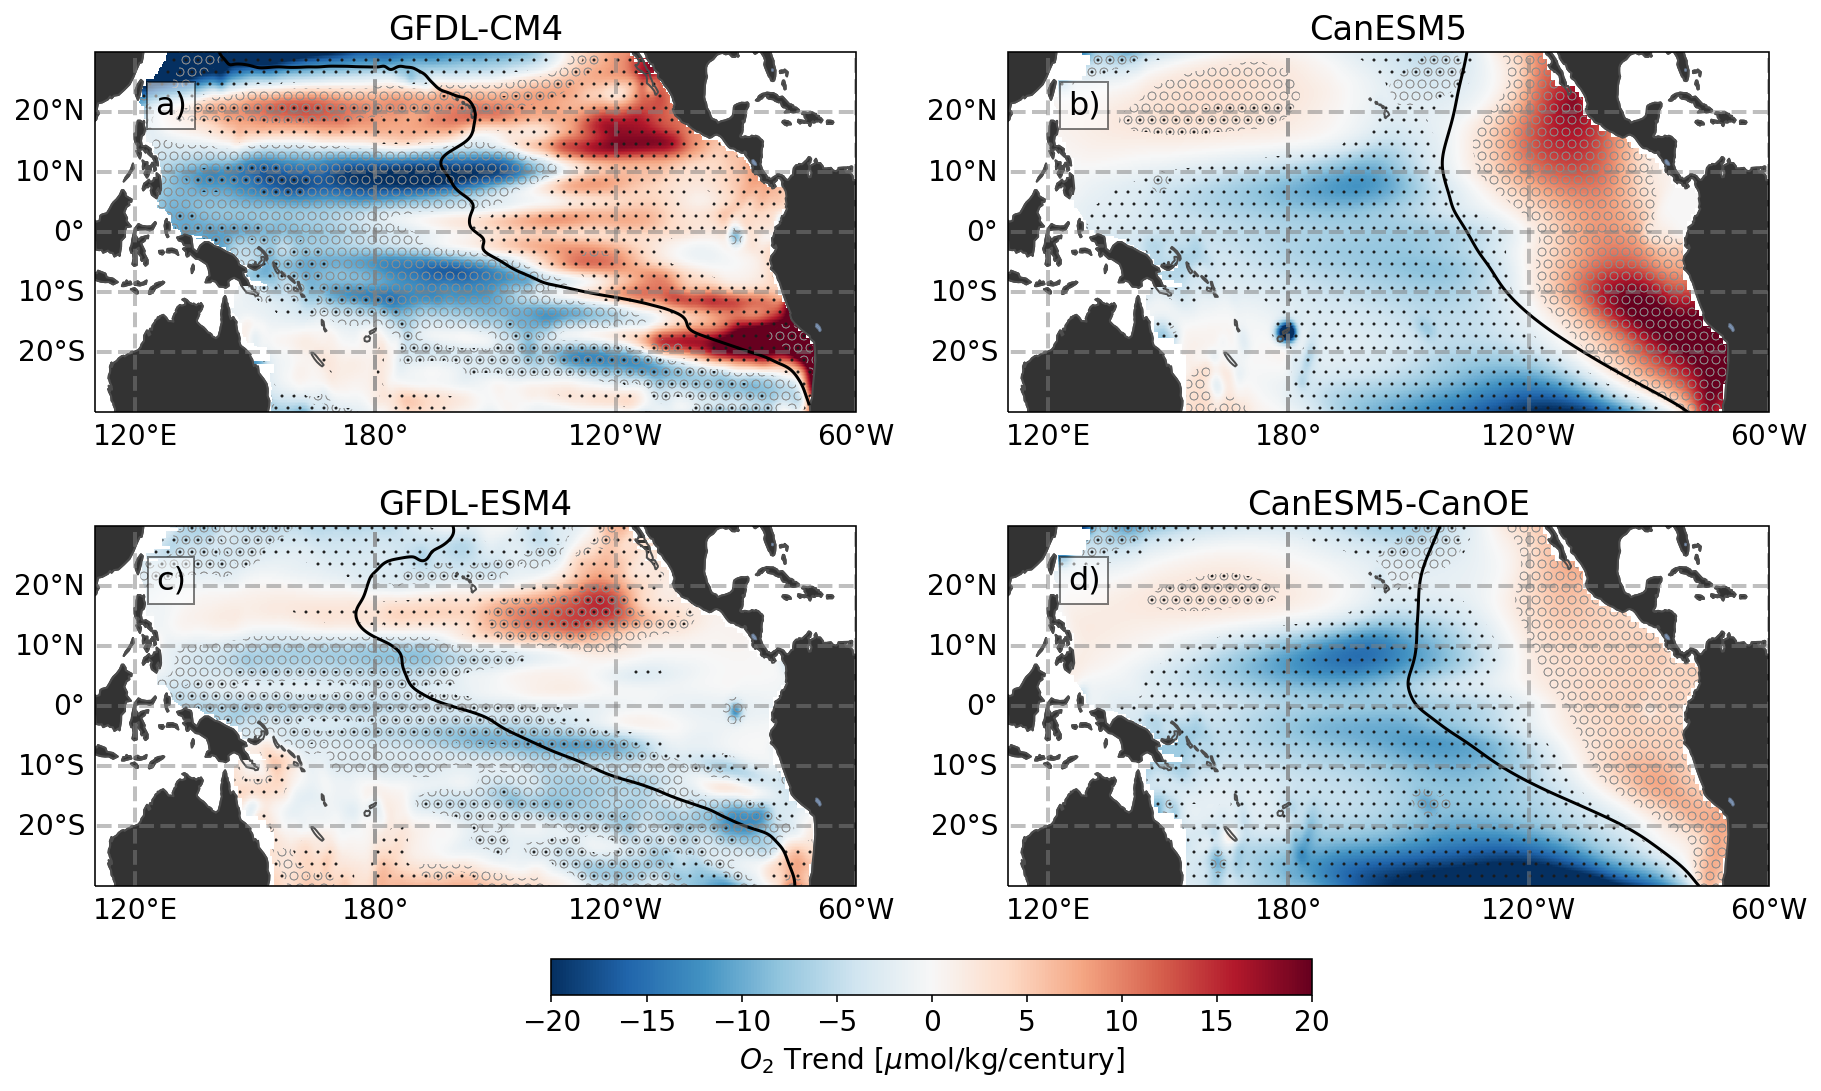

In [14]:
plt.rcParams['hatch.linewidth'] = 0.25
pick_models = ["GFDL-CM4", "CanESM5", "GFDL-ESM4", "CanESM5-CanOE"]

scale_factor = 2  # just used to wiggle the text and symbol sizes around
fontsize = 7 * scale_factor
plt.rcParams["font.size"] = str(fontsize)


fig, axarr = plt.subplots(
    ncols=2,
    nrows=2,
    subplot_kw={"projection": proj},
    figsize=np.array([7.5, 4])* scale_factor,
)

for mi, model in enumerate(pick_models):
    ds = ds_trend_sigma.isel(sigma_0=2).sel(model=model)
    omz = (
        convert_mol_m3_mymol_kg(ds_historical_sigma.o2)
        .isel(sigma_0=2)
        .sel(model=model)
        .squeeze()
    )
    ds = ds.sel(parameter="slope")  # .where(ds.sel(parameter='p_value')<sig_level)
    ds = ds * 100

    ds = filter_2D(ds.chunk({"x": -1, "y": -1}), filter_win, ["y", "x"])
    omz = filter_2D(omz.chunk({"x": -1, "y": -1}), filter_win, ["y", "x"])
    for var in ["o2", "our"]:
        ds[var] = convert_mol_m3_mymol_kg(ds[var])

    ds_delta = ds

    # print o2 field
    #     ax = axarr[mi, 0]
    ax = axarr.flat[mi]

    im = ds_delta["o2"].plot(
        ax=ax, add_labels=False, add_colorbar=False, vmax=20, rasterized=True, **map_kwargs
    )
    omz.plot.contour(ax=ax, levels=[-1e10,o2_bin], colors=["k"], **contour_kwargs, **map_kwargs)

    # calculate sign_agreement
    age_sign_agreement = (
        (np.sign(ds_delta.o2) == np.sign(ds_delta.agessc * -1))
        .squeeze()
        .where(~np.isnan(omz))
    )
    our_sign_agreement = (
        (np.sign(ds_delta.o2) == np.sign(ds_delta.our * -1))
        .squeeze()
        .where(~np.isnan(omz))
    )

    # mask agreement where change is very low
    o2_cut = 2
    age_sign_agreement = age_sign_agreement.where(abs(ds_delta["o2"]) >= o2_cut)
    our_sign_agreement = our_sign_agreement.where(abs(ds_delta["o2"]) >= o2_cut)

    ############ Shading the agreement 'blobs' according to the amplitude of the o2 change #####
    # This should help making those transitions a bit easier on the eyes.

    # imshow works a bit different than the other plots, need to define the extend or bounding box
    # Example here: https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/advanced_plotting.html
    img_extent = (
        ds_delta.lon.min().load().data.tolist(),
        ds_delta.lon.max().load().data.tolist(),
        ds_delta.lat.min().load().data.tolist(),
        ds_delta.lat.max().load().data.tolist(),
    )
    
#     plt.rcParams['hatch.color'] = '0.45'
    plt.rcParams['hatch.color'] = '0.1'
    
    age_sign_agreement.plot.contourf(
        ax=ax, levels=[0, 0.5], hatches=[None, ".."], **hatch_kwargs, **map_kwargs
    )
    
    plt.rcParams['hatch.color'] = '0.55'
#     plt.rcParams['hatch.color'] = '0.1'


    our_sign_agreement.plot.contourf(
        ax=ax, levels=[0, 0.5], hatches=[None, "OO"], **hatch_kwargs, **map_kwargs
    )

    polish_map(ax)
    ax.set_title(model)

cbar_ax = axarr[-1, 0]
axins = inset_axes(
    cbar_ax,
    width="100%",  # width = 50% of parent_bbox width
    height="10%",  # height : 5%
    bbox_to_anchor=(0.6, -0.75, 1, 1),
    bbox_transform=cbar_ax.transAxes,
    loc="center",
)

cbar = fig.colorbar(
    im,
    cax=axins,
    orientation="horizontal",
    ticks=np.arange(-40, 40, 5),
    label=f"$O_2$ Trend [$\mu$mol/kg/century]",
)
###################
# Label subplots
letter_subplots(axarr, box_color="w", fontsize=16)

# fig.savefig(plotfolder.joinpath("Figure4.png"), bbox_inches="tight", dpi=400)
fig.savefig(plotfolder.joinpath("Figure4.pdf"), bbox_inches="tight", dpi=400)
plt.show()

## Figure 6: Comparison to depth framework

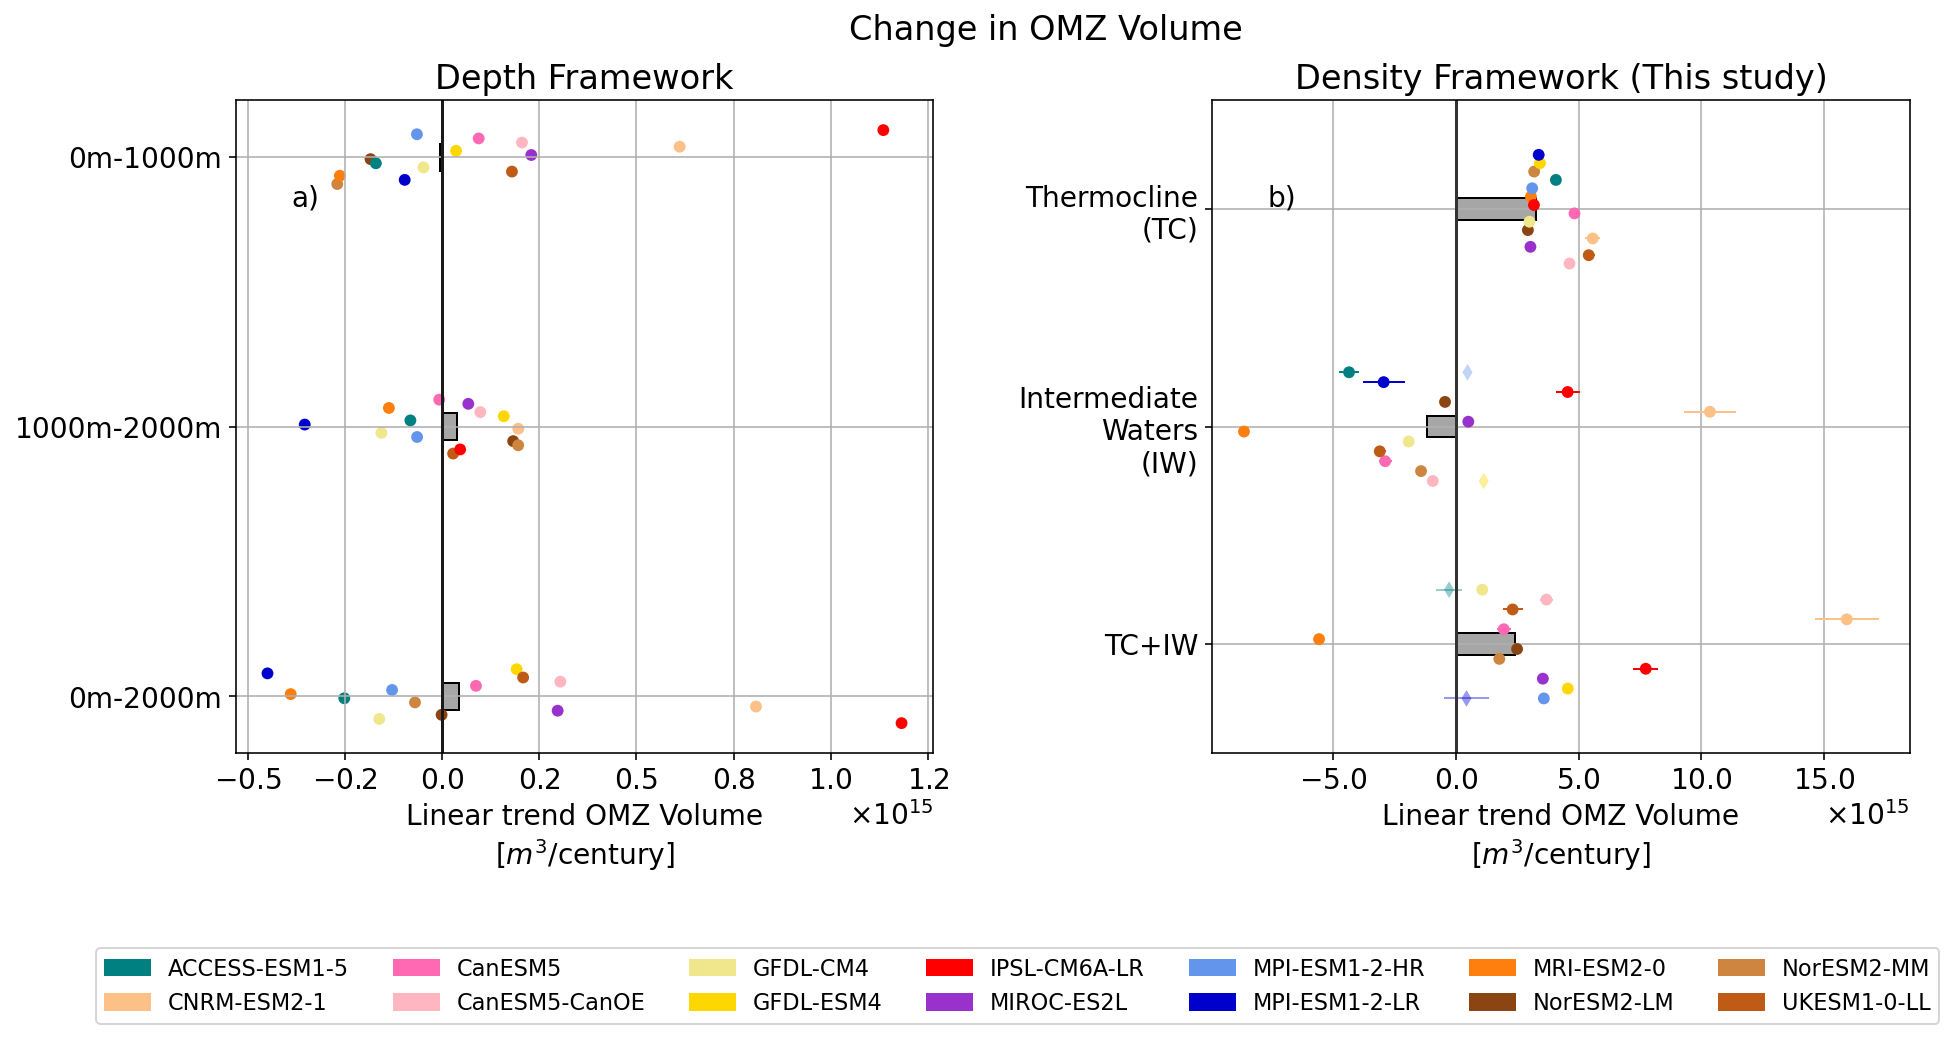

In [15]:
scale_factor = 2  # just used to wiggle the text and symbol sizes around
fontsize = 7 * scale_factor
plt.rcParams["font.size"] = str(fontsize)

fig, axarr = plt.subplots(ncols=2, figsize=np.array([7.5, 3]) * scale_factor)
o2_bin = 80

ax = axarr[0]
ticklabels = []
for pos, (upper, lower) in zip([0, 1, 2, 3], [(0, 2000), (1000, 2000), (0, 1000)]):

    label = f"{upper}m-{lower}m"
    model_dict = {
        ds.attrs["source_id"]: (ds.slope * 100)
        .sel(o2_bin=o2_bin, lev=slice(upper, lower))
        .sum("lev")
        .load()
        for model, ds in ddict_z_trend.items()
    }
    model_member_averaged = jitter_plot(pos, model_dict, ax=ax)

    # Model mean
    mean_vol = np.median(model_member_averaged)
    ax.barh(pos, mean_vol, edgecolor="k", height=bar_height, facecolor=bar_color, zorder=0)
    ticklabels.append(label)

ax.axvline(0, color="0.1")
ax.set_yticks(range(3))
ax.set_yticklabels(ticklabels)
# set the exponent to 15 for the bar plot
ax.xaxis.set_major_formatter(ScientificManualFormatter(15, "%1.1f"))
ax.ticklabel_format(axis="x", style="sci", scilimits=(-15, 15))
ax.grid()
ax.set_title("Depth Framework")
ax.set_xlabel("Linear trend OMZ Volume\n[$m^3$/century]")

#### Bar plots (same as Fig 2/3) #####
bar_ticks = np.arange(len(s_indicies))
ax_bar = axarr[1]
for s_idx, y, label in zip(s_indicies[0:3], bar_ticks[0:3], labels[0:3]):

    # historical volume for each model
    model_vol = {
        model: (ds.omz_volume.sel(o2_bin=o2_bin, parameter="slope"))
        .isel(sigma_0=s_idx)
        .sum("sigma_0")
        for model, ds in ddict_omz_trend.items()
    }

    if s_idx == [1, 2]:
        model_nat_var = {
            model: (ds.omz_volume_natural_variability.sel(o2_bin=o2_bin))
            for model, ds in ddict_nat_var_total.items()
        }
    else:
        model_nat_var = {
            model: (ds.omz_volume_natural_variability.sel(o2_bin=o2_bin)).isel(
                sigma_0=s_idx
            )
            for model, ds in ddict_nat_var.items()
        }

    model_mean = {model: (da * 100).load() for model, da in model_vol.items()}

    # average the members together if appropriate
    model_nat_var = {
        model: da.mean("member_id") if "member_id" in da.dims else da
        for model, da in model_nat_var.items()
    }
    model_mean_check = {
        model: da.mean("member_id") if "member_id" in da.dims else da
        for model, da in model_mean.items()
    }

    # split up versions that do not exceed the natural variability
    model_mean_significant = {
        model: da
        for model, da in model_mean.items()
        if abs(model_mean_check[model].data)
        > nat_var_multiples * model_nat_var[model].data
    }
    model_mean_insignificant = {
        model: da
        for model, da in model_mean.items()
        if model not in model_mean_significant.keys()
    }

    model_member_averaged_significant = jitter_plot(
        y, model_mean_significant, ax=ax_bar, marker="o", model_jitter_amount=0.25, s=40
    )
    if len(model_mean_insignificant) > 0:
        model_member_averaged_insignificant = jitter_plot(
            y,
            model_mean_insignificant,
            ax=ax_bar,
            marker="d",
            model_jitter_amount=0.25,
            alpha=0.4,
            s=10,
        )

        # Model mean
        model_member_averaged = np.hstack(
            [model_member_averaged_insignificant, model_member_averaged_significant]
        )
    else:
        # Model mean
        model_member_averaged = model_member_averaged_significant

    mean_vol = np.median(model_member_averaged)
    ax_bar.set_axisbelow(True)
    ax_bar.barh(y, mean_vol, edgecolor="k", height=bar_height, facecolor=bar_color, zorder=0)
    ax_bar.grid(zorder=-1)


# set the exponent to 15 for the bar plot
ax_bar.xaxis.set_major_formatter(ScientificManualFormatter(15, "%1.1f"))
ax_bar.ticklabel_format(axis="x", style="sci", scilimits=(-15, 15))

ax_bar.axvline(0, color="0.2")
# # ax_bar.set_title(label)
ax_bar.set_yticks(bar_ticks[0:3])
ax_bar.set_yticklabels(
    [
        l.replace(" ", "\n") for l in labels[0:3]
    ],  # ha="right", va="center" #rotation=90,
)
ax_bar.set_ylim([-0.5, 2.5])
ax_bar.invert_yaxis()


ax_bar.set_xlabel("Linear trend OMZ Volume\n[$m^3$/century]")
ax_bar.set_title("Density Framework (This study)")
fig.subplots_adjust(wspace=0.4)
fig.suptitle('Change in OMZ Volume')

model_color_legend(ax=ax,models=list(model_dict.keys()), ncol=7, bbox_to_anchor=(-0.2, -0.3), fontsize=fontsize*0.8)
letter_subplots(axarr, fontsize=fontsize)

fig.savefig(plotfolder.joinpath(f"Appendix_z_comparison_{o2_bin}.pdf"), bbox_inches="tight")
plt.show()

## Text: Mean and std of isopycnal depth in obs

In [16]:
obs_region = region(ds_obs_sigma.reset_coords(['lev', 'lev_bounds'])).load()
for sigma_idx, label in zip([1, 2], ["TC", "IW"]):
    da = obs_region.isel(sigma_0=sigma_idx).lev_bounds
    upper = da.isel(bnds=0)
    lower = da.isel(bnds=1)
    print(
        f"{label} depth range: Upper {upper.mean().data}+-{upper.std().data} - Lower {lower.mean().data}+-{lower.std().data}"
    )

TC depth range: Upper 112.01890084798738+-45.74433392965469 - Lower 338.5694528467972+-102.06534200507913
IW depth range: Upper 338.5694528467972+-102.06534200507913 - Lower 1894.716853502448+-41.08946029452815


# Appendix plots

## Figure 1 Appendix

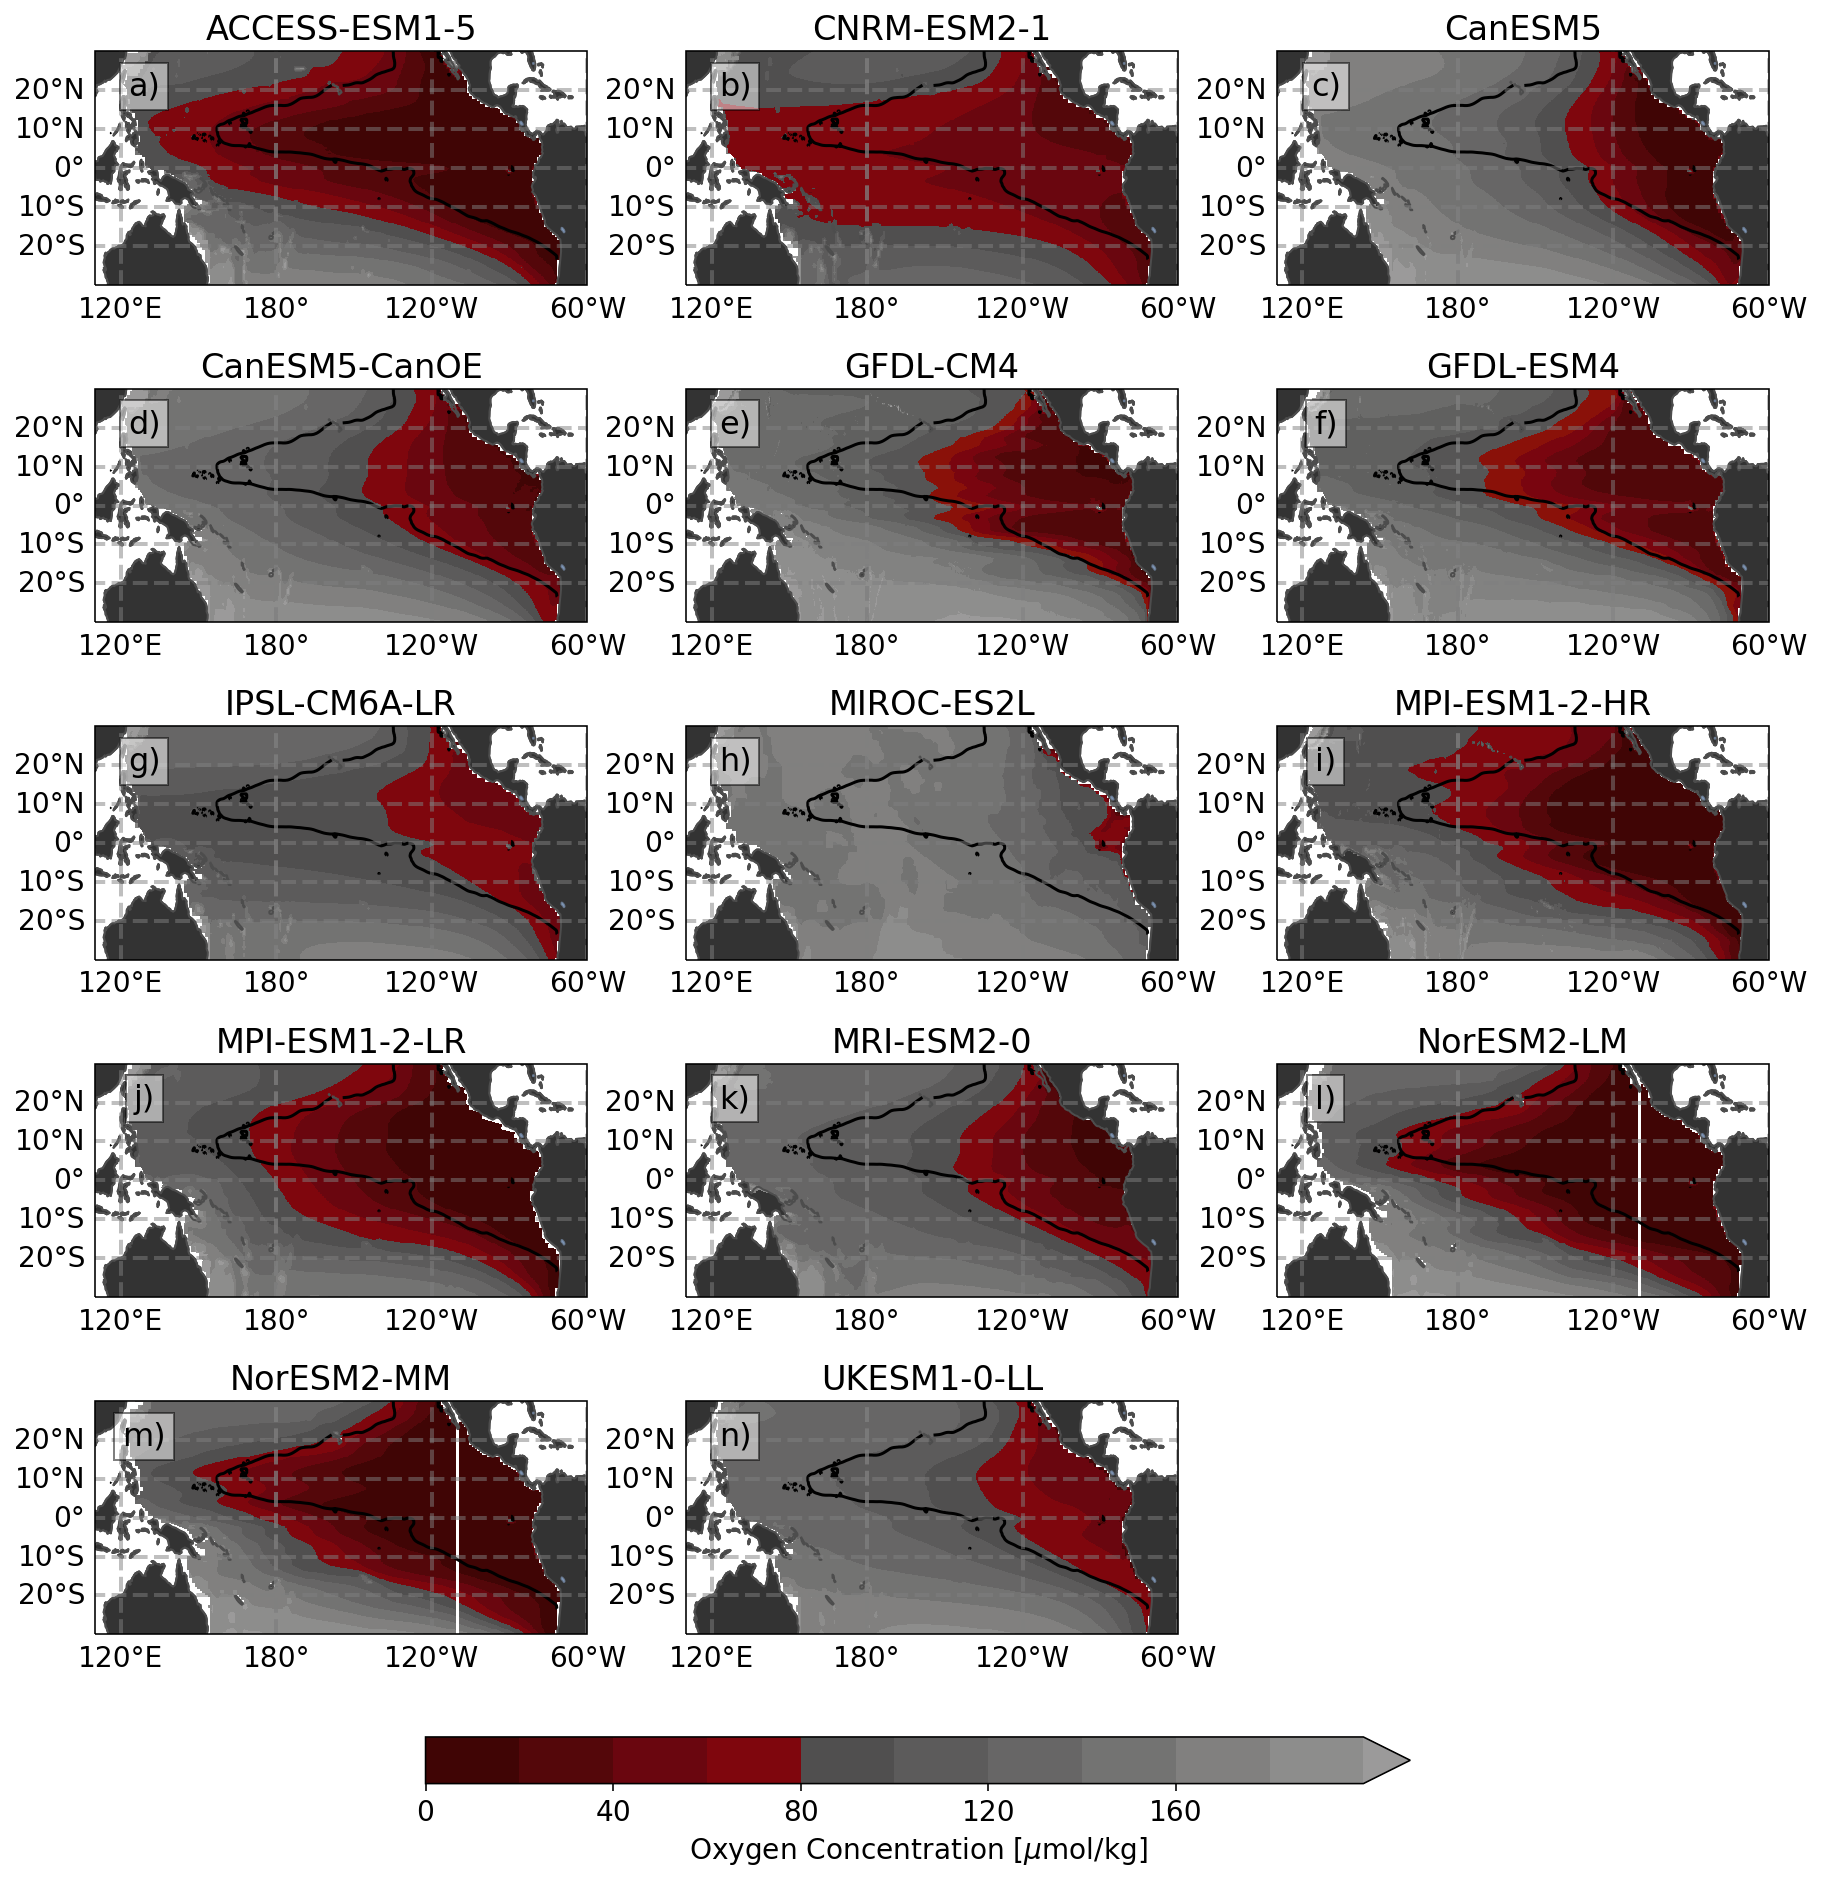

In [17]:
scale_factor = 2  # just used to wiggle the text and symbol sizes around
fontsize = 7 * scale_factor
plt.rcParams["font.size"] = str(fontsize)

fig, axarr = plt.subplots(
    ncols=3,
    nrows=5,
    figsize=np.array([7.5, 7.5]) * scale_factor,
    subplot_kw=dict(projection=proj),
)
################################    thermocline o2 map   ####################################
o2_obs = convert_mol_m3_mymol_kg(ds_obs_sigma.o2).isel(sigma_0=[1, 2])
o2_obs = o2_obs.weighted(o2_obs.dz_t.fillna(0)).mean("sigma_0")

for ax, model in zip(axarr.flat, ds_historical_sigma.model.data):

    o2 = (
        convert_mol_m3_mymol_kg(ds_historical_sigma.o2)
        .sel(model=model)
        .isel(sigma_0=[1, 2])
    )
    o2 = o2.weighted(o2.dz_t.fillna(0)).mean("sigma_0")

    im = o2.plot(ax=ax, **map_kwargs, **color_kwargs, add_colorbar=False)
    o2_obs.plot.contour(ax=ax, levels=[-1e10,o2_bin], colors="k", **map_kwargs)
    polish_map(ax)
    ax.set_title(f"{model}")
#     break

axarr[-1, -1].remove()
############################################################################################
# set global colorbar


cbar_ax = axarr[-1, 1]
axins = inset_axes(
    cbar_ax,
    width="200%",  # width = 50% of parent_bbox width
    height="20%",  # height : 5%
    bbox_to_anchor=(0.5, -0.7, 1, 1),
    bbox_transform=cbar_ax.transAxes,
    loc="lower right",
)

cbar = fig.colorbar(
    im,
    cax=axins,
    orientation="horizontal",
    ticks=np.arange(0, 200, 40),
    label=f"Oxygen Concentration [$\mu$mol/kg]",
)
###################
# Label subplots
letter_subplots(axarr, box_color="w", fontsize=16)

fig.savefig(
    plotfolder.joinpath("Appendix_single_model_maps.png"), bbox_inches="tight", dpi=400
)
plt.show()

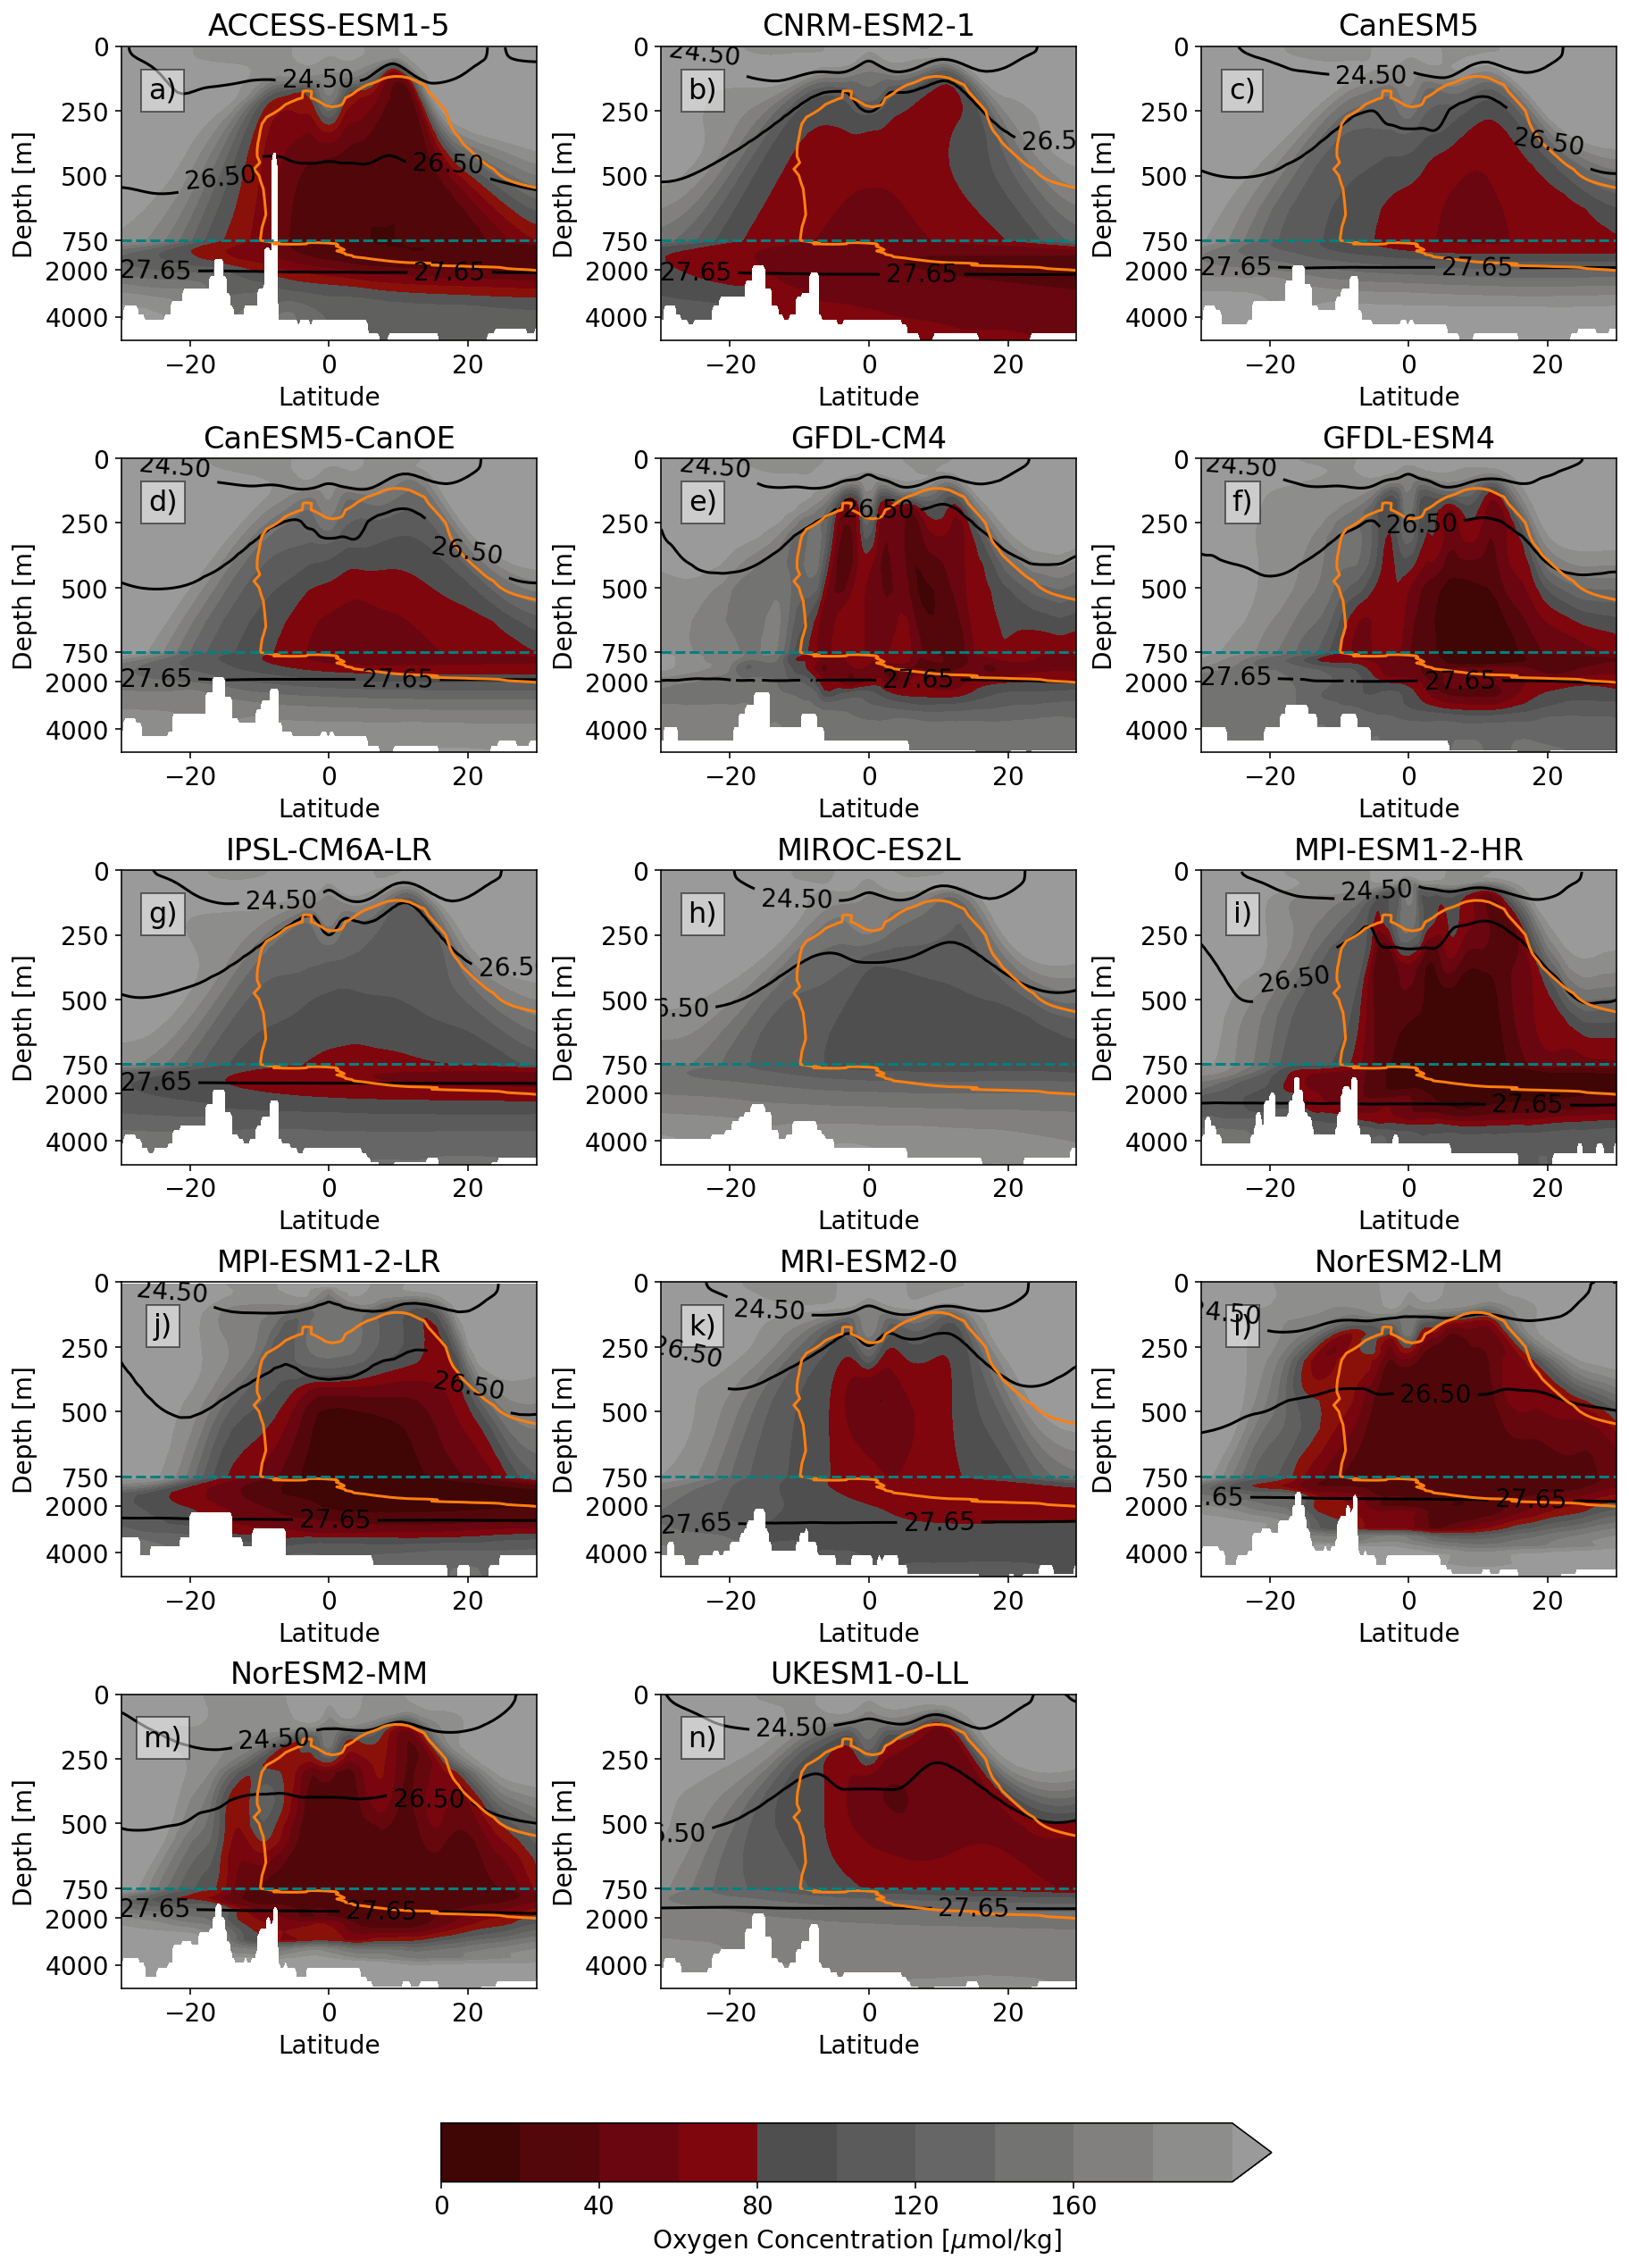

In [18]:
scale_factor = 2  # just used to wiggle the text and symbol sizes around
fontsize = 7 * scale_factor
plt.rcParams["font.size"] = str(fontsize)

fig, axarr = plt.subplots(
    ncols=3, nrows=5, figsize=np.array([7.5, 10])*scale_factor)
################################    thermocline o2 map   ####################################
o2_obs = convert_mol_m3_mymol_kg(obs_z.o2).interp(x=ref_lon)

for ax, model in zip(axarr.flat, ds_historical_sigma.model.data):
    data = full_z.sel(model=model).interp(x=ref_lon)
    o2 = convert_mol_m3_mymol_kg(data.o2)
    sigma = data.sigma_0

    im = o2.plot.contourf(
    ax=ax, **color_kwargs, add_colorbar=False, **section_kwargs
    )
    ch_dens = sigma.plot.contour(
        ax=ax, levels=sigma_contours, colors="k", **section_kwargs, **contour_kwargs
    )
    plt.clabel(ch_dens, fmt="%.2f")
    #compare to obs
    o2_obs.plot.contour(
        ax=ax, levels=[-1e10,o2_bin], colors="C1", **section_kwargs, **contour_kwargs
    )

    ax.set_title(model)
    linear_piecewise_scale(750, 10, ax=ax)
    ax.axhline(750, color="teal", ls="--")
    # indicate the point between the different scalings
    ax.set_ylim(5000, 0)
    ax.set_xlabel('Latitude')
    # Rearange the yticks
    ax.set_yticks([0, 250, 500, 750, 2000, 4000])
    ax.set_ylabel('Depth [m]')

axarr[-1, -1].remove()
############################################################################################
# set global colorbar


cbar_ax = axarr[-1, 1]
axins = inset_axes(
    cbar_ax,
    width="200%",  # width = 50% of parent_bbox width
    height="20%",  # height : 5%
    bbox_to_anchor=(0.5, -0.7, 1, 1),
    bbox_transform=cbar_ax.transAxes,
    loc="lower right",
)

cbar = fig.colorbar(
    im,
    cax=axins,
    orientation="horizontal",
    ticks=np.arange(0, 200, 40),
    label=f"Oxygen Concentration [$\mu$mol/kg]",
)
###################
# Label subplots
letter_subplots(axarr, box_color="w", fontsize=16)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

fig.savefig(plotfolder.joinpath("Appendix_single_model_sections.png"), bbox_inches="tight")
plt.show()

## consistency across oxygen thresholds

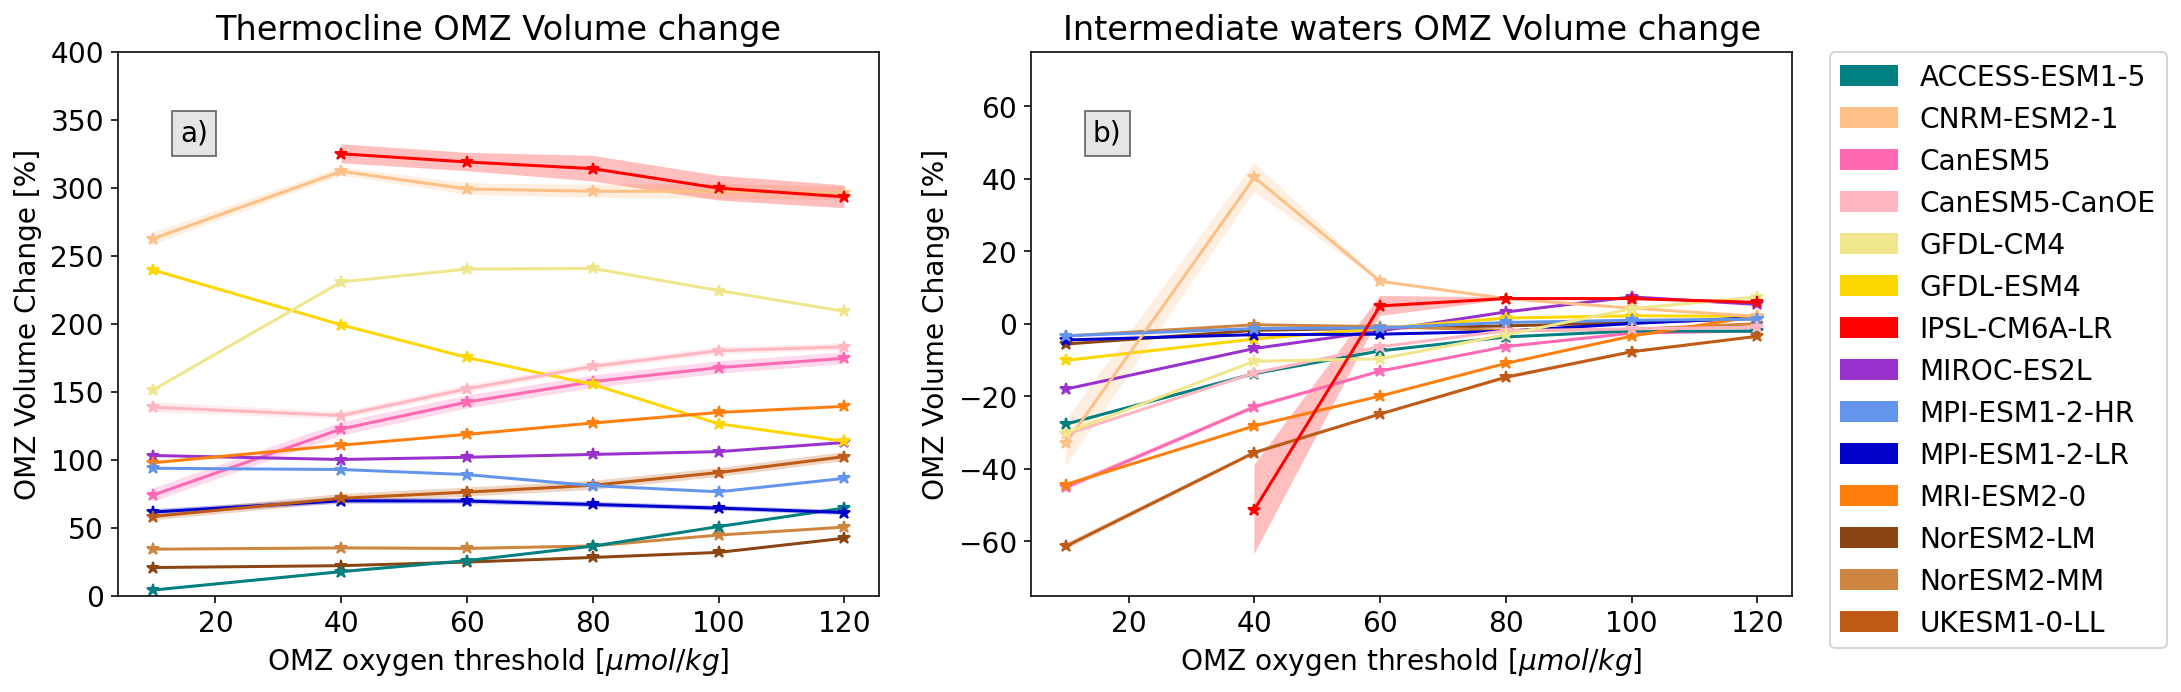

In [19]:
scale_factor = 2  # just used to wiggle the text and symbol sizes around
fontsize = 7 * scale_factor
plt.rcParams["font.size"] = str(fontsize)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=np.array([7.5,2.5])*scale_factor)
for ax, sigma_idx in zip([ax1, ax2], [1,2]):
    for model, ds in ddict_omz_trend.items():

        da_hist = ddict_full[model].omz_volume.sel(time=slice('1960', '2000')).isel(sigma_0=sigma_idx).mean('time')
        da = ds.omz_volume.isel(sigma_0=sigma_idx).sel(parameter='slope') * 100 # change over 100 years
        da = da/da_hist*100
        da = da.where(da_hist>5e13)
        shaded_line_plot(da, 'member_id', ax=ax, spread_style='std', spreads=[1],line_kwargs=dict(color=o2_model_colors()[model], marker='*'))

for ax, layer in zip([ax1, ax2], ['Thermocline', 'Intermediate waters']):
    
    ax.set_title(f'{layer} OMZ Volume change')
    ax.set_ylabel('OMZ Volume Change [%]')
    ax.set_xlabel('OMZ oxygen threshold [$\mu mol/kg$]')
ax1.set_ylim(0,400)
ax2.set_ylim(-75,75)
letter_subplots(np.array([ax1, ax2]), fontsize=fontsize, box_color='0.8')
model_color_legend(ax2, models=np.array(list(ddict_full.keys())))
fig.savefig(plotfolder.joinpath('Appendix_threshold_consistency.pdf'), bbox_inches="tight")

## Appendix: Changes in thickness/o2 per model 

NameError: name 'mticker' is not defined

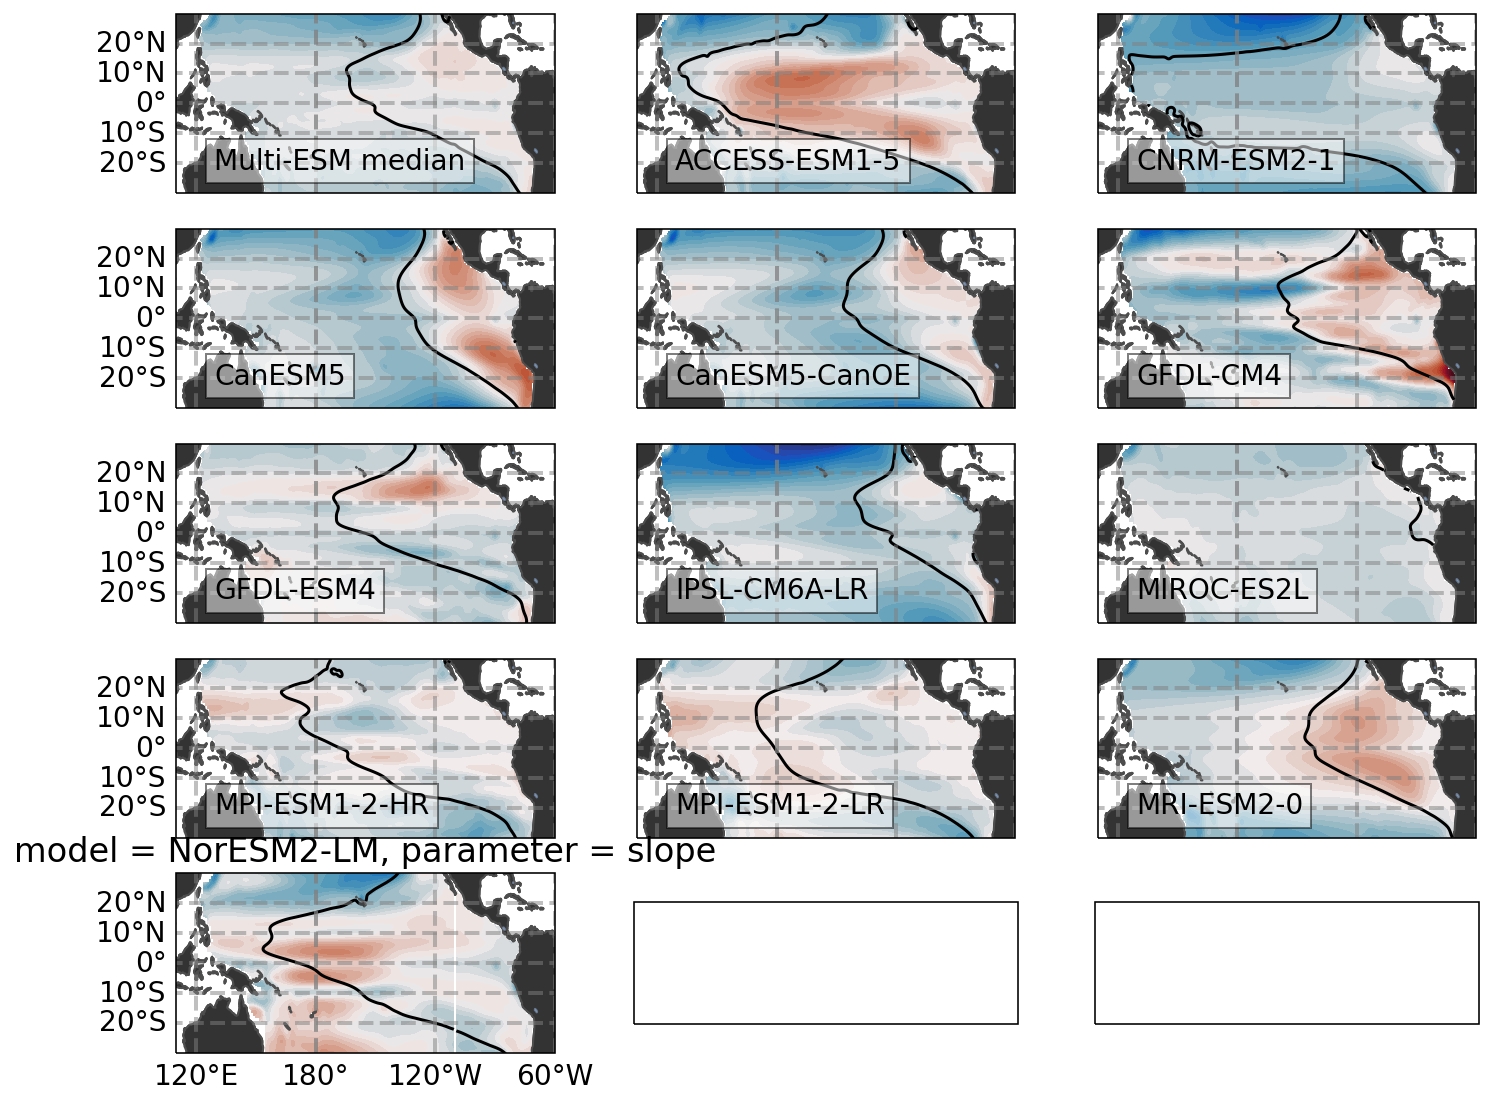

In [20]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    for variable in ["o2", "thickness"]:
        fig, axarr = plt.subplots(
            ncols=3,
            nrows=5,
            subplot_kw={"projection": proj},
            figsize=np.array([9, 7.35]) * 1.3,
            sharex=True,
            sharey=True,
        )

        s_idx = [1,2]
        label = "Thermocline\n+\nIntermediate Waters"
        
        for mi, model in enumerate(["all"] + list(models)):
            ax = axarr.flat[mi]

            # Reference o2 field for contours
            ref_o2 = ds_historical_sigma.isel(sigma_0=s_idx)
            ref_o2 = ref_o2.o2.weighted(ref_o2.dz_t.fillna(0)).mean("sigma_0")
            ref_o2 = convert_mol_m3_mymol_kg(ref_o2)

            # oxygen trend
            if variable == "o2":
                color_data = ds_trend_sigma.o2
                color_data = convert_mol_m3_mymol_kg(color_data)
                units = "$\mu mol/kg$"
                title = "$O_2$"
                vmax = 100
                tick_levels = np.arange(-40, 50, 10)
                levels = np.arange(-41, 42, 2)
            elif variable == "thickness":
                color_data = ds_trend_sigma.omz_thickness.sel(o2_bin=o2_bin)
                units = "m"
                title = "OMZ thickness"
                vmax = 100
                tick_levels = np.arange(-210, 220, 30)
                levels = np.arange(-195, 200, 10)


            # scale to trend/century
            color_data = color_data.sel(parameter="slope") * 100

            # sum/average over density layers
            if variable == "o2":
                # This is an approximation. A more precise way to do it would be to do the trend over an extensive quantity.
                # But since this is just used for a qualitative comparison in the Appendix we will stick with this simpler version.
                color_data = (
                    color_data.isel(sigma_0=s_idx)
                    .weighted(ds_historical_sigma.dz_t.fillna(0))
                    .mean("sigma_0")
                )
            elif variable == "thickness":
                color_data = color_data.isel(sigma_0=s_idx).sum("sigma_0")

            # mask out land
            mask = np.isnan(ref_o2).sum("model") > 2
            color_data = color_data.where(~mask)

            # average over models if applicable
            if model == "all":
                if median:
                    color_data = color_data.median("model")
                    ref_o2 = ref_o2.median("model")
                else:
                    color_data = color_data.mean("model")
                    ref_o2 = ref_o2.mean("model")
            else:
                color_data = color_data.sel(model=model)
                ref_o2 = ref_o2.sel(model=model)


            # finally smooth the output
            color_data = filter_2D(
                color_data.chunk({"x": -1, "y": -1}), filter_win, ["y", "x"]
            )
            ref_o2 = filter_2D(
                ref_o2.chunk({"x": -1, "y": -1}), filter_win, ["y", "x"]
            )

            im = color_data.plot.contourf(
                ax=ax,
                robust=True,
                center=0,
                vmax=vmax,
                cmap=cmo.balance,
                levels=levels,
                add_colorbar=False,
                **map_kwargs,
            )

            ref_o2.plot.contour(
                ax=ax,
                levels=[-1e10, o2_bin],
                colors=["k"],
                add_colorbar=False,
                add_labels=False,
                **map_kwargs,
            )

            lat_labels = "left" if ax in axarr[:,0] else None
            lon_labels = "bottom" if ax in axarr[-1,:] else None
            lon_ticks = [120, 180, -120] if ax in axarr[-1,:] else None
            polish_map(
                ax,
                lon_labels=lon_labels,
                lat_labels=lat_labels,
                lon_ticks=lon_ticks,
            )

            ax.set_title("")
            ax.text(
                0.1,
                0.1,
                f"{'Multi-ESM median' if model == 'all' else model}",
                horizontalalignment="left",
                verticalalignment="bottom",
                transform=ax.transAxes,
                color="k",
                bbox=dict(facecolor="w", alpha=0.5),
            )

        # set global colorbar
        cbar_ax = axarr[-1, 0]
        axins = inset_axes(
            cbar_ax,
            width="300%",  # width = 50% of parent_bbox width
            height="20%",  # height : 5%
            bbox_to_anchor=(0.9, -0.5, 1, 1),
            bbox_transform=cbar_ax.transAxes,
            loc="lower center",
        )

        cbar = fig.colorbar(
            im,
            cax=axins,
            orientation="horizontal",
            ticks=tick_levels,
            label=f"{title} trend [{units}/century]",
        )
        letter_subplots(
            axarr, box_color="w", fontsize=fontsize
        )
        fig.subplots_adjust(hspace=0, wspace=0)
        fig.savefig(
            plotfolder.joinpath(f"Appendix_{variable}_simplified.png"), bbox_inches="tight", dpi=300
        )
        plt.show()

## Appendix: Deep Layer info

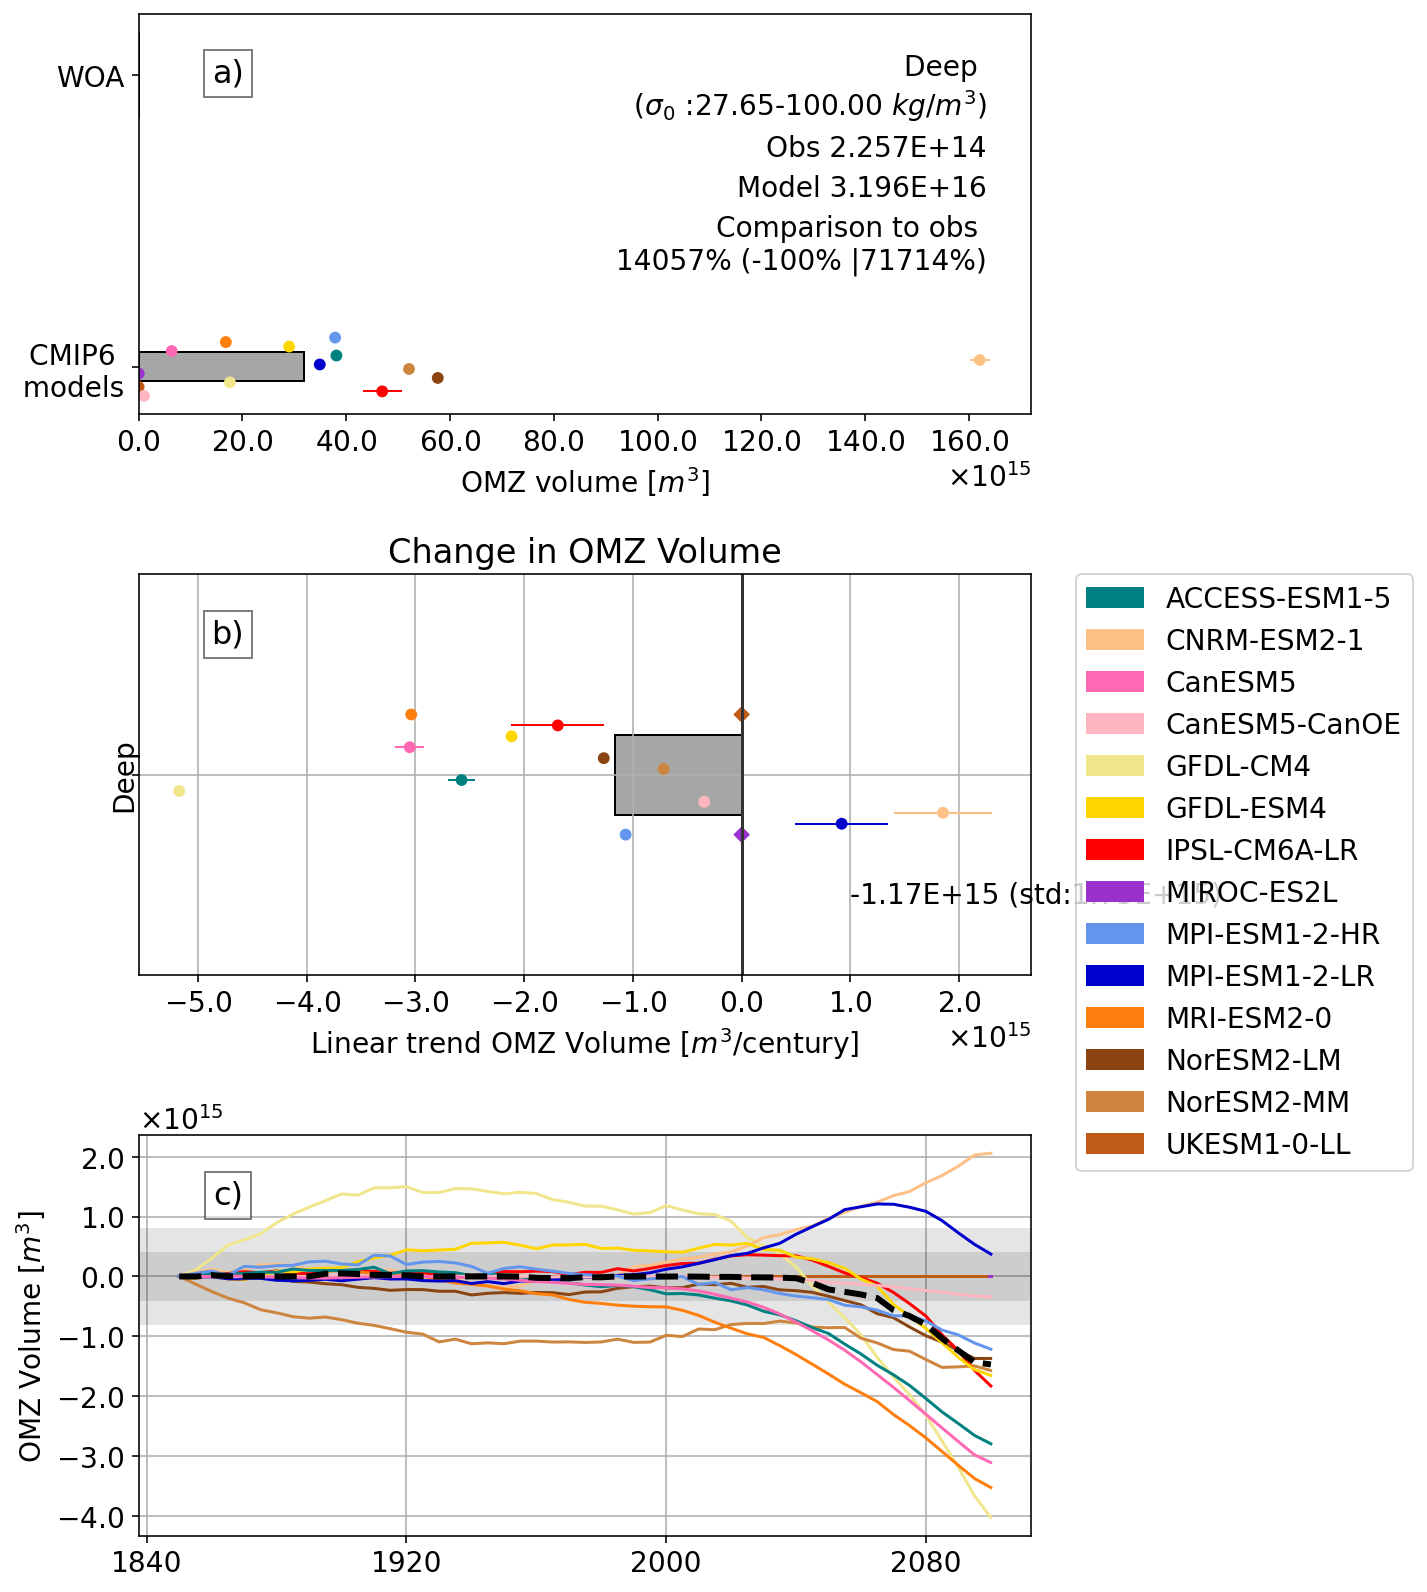

In [21]:
########################## Figure setup ##################################
scale_factor = 2  # just used to wiggle the text and symbol sizes around
fontsize = 7 * scale_factor
plt.rcParams["font.size"] = str(fontsize)

fig = plt.figure(constrained_layout=False, figsize=np.array([4, 7]) * scale_factor)
gs = fig.add_gridspec(3, 1)
ax_bar_hist = fig.add_subplot(gs[0, 0])
ax_bar = fig.add_subplot(gs[1, 0])
ax_ts = fig.add_subplot(gs[2, 0])


bar_ticks = np.arange(len(s_indicies))

######################### historical Volume ########################################
for s_idx, label, ax, ax_lim_format in zip(
    s_indicies[3:], labels[3:], [ax_bar_hist], [15]
):
    # observed volume
    obs_vol = (
        ds_obs_sigma.omz_volume.sel(o2_bin=o2_bin).isel(sigma_0=s_idx).sum("sigma_0")
    )
    # historical volume for each model
    model_vol = {
        model: ds.omz_volume.sel(time=historical_time, o2_bin=o2_bin)
        .isel(sigma_0=s_idx)
        .sum("sigma_0")
        for model, ds in ddict_full.items()
    }
    model_mean = {model: ds.mean("time").load() for model, ds in model_vol.items()}
    model_std = {model: ds.std("time").load() for model, ds in model_vol.items()}

    # compare to observed value
    ax.barh(1, obs_vol, color="k", height=bar_height)

    model_member_averaged = jitter_plot(
        0,
        model_mean,
        ax=ax,
        model_jitter_amount=model_jitter,
    )

    # Model mean
    mean_vol = np.median(model_member_averaged)
    ax.barh(0, mean_vol, edgecolor="k", height=bar_height, facecolor=bar_color, zorder=0)

    ax.set_xlabel("OMZ volume [$m^3$]")
    # this might have to be adjusted?
    sigma_bounds = [
        ds_historical_sigma.isel(sigma_0=s_idx).sigma_0_bounds.min().load().data,
        ds_historical_sigma.isel(sigma_0=s_idx).sigma_0_bounds.max().load().data,
    ]
    ax.text(
        0.95,
        0.9,
        f"{label} \n ($\sigma_0$ :{sigma_bounds[0]:.2f}-{sigma_bounds[1]:.2f} $kg/m^3$)",
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax.transAxes,
    )
    ax.xaxis.set_major_formatter(ScientificManualFormatter(ax_lim_format, "%1.1f"))
    ax.ticklabel_format(
        axis="x", style="sci", scilimits=(-ax_lim_format, ax_lim_format)
    )
    ax.set_yticks([0, 1])
    ax.set_yticklabels(
        [
            "CMIP6 \n models",
            "WOA",
        ]
    )

    # add the percent difference of the mean/median and Range of single models
    obs_vol = np.array(obs_vol)
    comparison_perc = (mean_vol - obs_vol) / obs_vol * 100
    comparison_min = np.min((model_member_averaged - obs_vol) / obs_vol * 100)
    comparison_max = np.max((model_member_averaged - obs_vol) / obs_vol * 100)

    ax.text(
        0.95,
        0.7,
        f"Obs {obs_vol:.3E}",
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax.transAxes,
    )

    ax.text(
        0.95,
        0.6,
        f"Model {mean_vol:.3E}",
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax.transAxes,
    )

    ax.text(
        0.95,
        0.5,
        f"Comparison to obs \n {comparison_perc:.0f}% ({comparison_min:.0f}% |{comparison_max:.0f}%)",
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax.transAxes,
    )

######################### Bar plots ################################################
for s_idx, y, label in zip([s_indicies[3]], [bar_ticks[3]], [labels[3]]):

    # historical volume for each model
    model_vol = {
        model: (ds.omz_volume.sel(o2_bin=o2_bin, parameter="slope"))
        .isel(sigma_0=s_idx)
        .sum("sigma_0")
        for model, ds in ddict_omz_trend.items()
    }
    model_nat_var = {
        model: (ds.omz_volume_natural_variability.sel(o2_bin=o2_bin))
        .isel(sigma_0=s_idx)
        .sum("sigma_0")
        for model, ds in ddict_nat_var.items()
    }
    model_mean = {model: (da * 100).load() for model, da in model_vol.items()}

    # average the members together if appropriate
    model_nat_var = {
        model: da.mean("member_id") if "member_id" in da.dims else da
        for model, da in model_nat_var.items()
    }
    model_mean_check = {
        model: da.mean("member_id") if "member_id" in da.dims else da
        for model, da in model_mean.items()
    }

    #
    #     # standard version
    #     model_member_averaged = jitter_plot(y, model_mean, ax=ax_bar, marker='*')

    # split up versions that do not exceed the natural variability
    model_mean_significant = {
        model: da
        for model, da in model_mean.items()
        if abs(model_mean_check[model].data) > 4 * model_nat_var[model].data
    }
    model_mean_insignificant = {
        model: da
        for model, da in model_mean.items()
        if model not in model_mean_significant.keys()
    }

    model_member_averaged_significant = jitter_plot(
        y, model_mean_significant, ax=ax_bar, marker="o", model_jitter_amount=0.15
    )
    if len(model_mean_insignificant) > 0:
        model_member_averaged_insignificant = jitter_plot(
            y, model_mean_insignificant, ax=ax_bar, marker="D", model_jitter_amount=0.15
        )

    # Model mean
    model_member_averaged = np.hstack(
        [model_member_averaged_insignificant, model_member_averaged_significant]
    )
    mean_vol = np.median(model_member_averaged)
    ax_bar.set_axisbelow(True)
    ax_bar.barh(y, mean_vol, edgecolor="k", height=bar_height, facecolor=bar_color, zorder=-1)
    ax_bar.set_axisbelow(False)

    # add the total change and std of models as text

    ax_bar.text(
        1e15,
        y + 0.3,  # a bit hacky...
        f"{np.median(model_member_averaged):.2E} (std:{np.std(model_member_averaged):.2E})",
        horizontalalignment="left",
        verticalalignment="center",
        #         transform=ax_bar.transAxes,
    )

# set the exponent to 15 for the bar plot
ax_bar.xaxis.set_major_formatter(ScientificManualFormatter(15, "%1.1f"))
ax_bar.ticklabel_format(axis="x", style="sci", scilimits=(-15, 15))

ax_bar.axvline(0, color="0.2")
# # ax_bar.set_title(label)
ax_bar.set_yticks([y])
ax_bar.set_yticklabels([label], rotation=90, ha="center", va="center")
ax_bar.set_ylim([2.5, 3.5])
ax_bar.invert_yaxis()
ax_bar.set_axisbelow(True)
ax_bar.grid()

ax_bar.set_xlabel("Linear trend OMZ Volume [$m^3$/century]")
ax_bar.set_title("Change in OMZ Volume")

######################################## timeseries ##############################################
ax = ax_ts
sigma_idx = [3]
multimodel = []
max_variability = []
for model, ds in ddict_full.items():

    color = o2_model_colors()[model]

    # restrict to 1850-2100 (IPSL and CanESM have longer members)
    ds = ds.sel(time=slice("1850", "2100"))

    ds_nat_var = ddict_nat_var[model]

    ds = ds.sel(o2_bin=o2_bin).isel(sigma_0=sigma_idx).sum(["sigma_0"])
    ds_nat_var = ds_nat_var.sel(o2_bin=o2_bin).isel(sigma_0=sigma_idx).sum(["sigma_0"])

    # smooth for 5 years
    ds = ds.resample(time=freq).mean()

    omz_vol = ds.omz_volume
    natural_variability = ds_nat_var.omz_volume_natural_variability

    if "member_id" in omz_vol.dims:
        # remove the baseline, so the mean value starts at 0
        baseline = omz_vol.mean("member_id").isel(time=0)
        omz_vol = omz_vol - baseline
        # this is visually overwhelming. Save it for the appendix?
        #         omz_vol.plot(hue='member_id', color=color, alpha=0.5, add_legend=False)
        omz_vol = omz_vol.mean("member_id")
        multimodel.append(omz_vol)
        omz_vol.plot(ax=ax, color=color, lw=1.5, add_legend=False)
    else:
        baseline = omz_vol.isel(time=0)
        omz_vol = omz_vol - baseline
        multimodel.append(omz_vol)
        omz_vol.plot(ax=ax, color=color, lw=1.5, add_legend=False)

    # if there are several members, average them
    if "member_id" in natural_variability.dims:
        natural_variability = natural_variability.mean("member_id")
    max_variability.append(natural_variability)

    def concat_multi_model(datasets):
        if "time" in datasets[0].dims:
            datasets = [
                replace_time(
                    ds, ref_date=ds.time.data[0], calendar="standard", freq=freq
                )
                for ds in datasets
            ]
        return xr.concat(
            datasets, dim="model", compat="override", coords="minimal", join="override"
        )


ds_multimodel = concat_multi_model(multimodel).median("model")
ds_max_var = concat_multi_model(max_variability).max("model")
ds_multimodel.plot(ax=ax, color="k", lw=3, ls="--")

ax.set_axisbelow(True)
axhpatch(2 * ds_max_var, edgecolor="none", facecolor="k", alpha=0.1, ax=ax)
axhpatch(ds_max_var, edgecolor="none", facecolor="k", alpha=0.1, ax=ax)

ax.grid()
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("OMZ Volume [$m^3$]")

# set the exponent to 15 for the bar plot
ax.yaxis.set_major_formatter(ScientificManualFormatter(15, "%1.1f"))
ax.ticklabel_format(axis="y", style="sci", scilimits=(-15, 15))

letter_subplots(
    np.array([ax_bar_hist] + [ax_bar] + [ax_ts]), box_color="w", fontsize=16
)

model_color_legend(ax_bar, models=models, fontsize=fontsize)
fig.subplots_adjust(hspace=0.4)
fig.savefig(plotfolder.joinpath("Appendix_deep.pdf"), bbox_inches="tight")
plt.show()